<h1> Title: Emotion Recognition in text</h1>

<strong>Overview: In this notebook, I aim to detect and categorize emotion in text using GoEmotions datasets</strong><br>
In this notebook, it covers:<br>
1.0 Obtain and combine necessary data from original GoEmotions datasets<br>
2.0 Data understanding<br>
3.0 Text Preprocessing<br>
4.0 Data Splitting<br>
5.0 Feature Extraction<br>
6.0 Model Development<br>
6.1 Machine Learning models<br>
6.2 Deep Learning models<br>
6.3 Transformer models<br>
7.0 Deployment<br>


Characteristics of GoEmotions:
- Application Domain: social media
- Size: 58,009 sentences
- Imbalanced
- Multi-label
- Emotion labeled: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral

In [1]:
# Basic Libraries
import pandas as pd  
import numpy as np  
import random  
import warnings  
import json

# Text Processing Libraries
import nltk  
import contractions  
import re  
from collections import Counter  # Word frequency counting

# Tokenization, Stopwords, Stemming, and Lemmatization
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords, wordnet  
from nltk.stem import PorterStemmer, WordNetLemmatizer  

# Feature Extraction Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # Text vectorization
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import IterativeStratification
from sklearn.utils.class_weight import compute_class_weight  
import gensim.downloader  # Pretrained word embeddings

# Multilabel Classification Libraries
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# Machine Learning Model Libraries
from sklearn.naive_bayes import MultinomialNB  
from xgboost import XGBClassifier

# Deep Learning Libraries
import tensorflow as tf  
from tensorflow.keras.preprocessing.text import Tokenizer  # Tokenization for deep learning
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Sequence padding
from tensorflow.keras.models import Sequential, Model  # Model building
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout,
    Bidirectional, LSTM, Input, Concatenate, BatchNormalization, LayerNormalization,  MultiHeadAttention, Add
)  # Layers for deep learning models
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.regularizers import l2  # Regularization
from tensorflow.keras.callbacks import EarlyStopping 

# Transformer-Based Libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW

# Statistical mode function
from scipy.stats import mode  

# File Handling & Serialization
import pickle  # Save and load Python objects
import os  # OS file operations
from pathlib import Path  # Path management

# Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt  
from wordcloud import WordCloud  # Word cloud generation

# Performance Evaluation Metrics
from sklearn.metrics import (
    f1_score, hamming_loss, jaccard_score, f1_score, classification_report, precision_recall_curve, roc_auc_score
)  

# Ignore Warnings
warnings.filterwarnings("ignore")

# Download Required NLTK Resources
nltk.download('punkt')  # Tokenization
nltk.download('stopwords')  # Stopwords list
nltk.download('averaged_perceptron_tagger')  # POS tagging
nltk.download('wordnet')  # WordNet corpus for lemmatization
nltk.download('omw-1.4')  # WordNet synonyms

c:\Users\User\Documents\UTAR\Y3S2 D\fyp\01 fyp\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nlt

True

---
# 1.0 Obtain dataset
- The dataset is obtained from goemotions_1.csv, goemotions_2.csv, goemotions_3.csv and stored in separate GoEmotions.csv.

In [17]:
file_paths = [
    '../Datasets/goemotions_1.csv',
    '../Datasets/goemotions_2.csv',
    '../Datasets/goemotions_3.csv'
]

# Define emotion columns (28 emotions)
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Load and combine datasets
dfs = []
for f in file_paths:
    df = pd.read_csv(f)
    
    # Ensure emotion columns exist
    for col in emotion_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing emotion column
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# Calculate label distribution
combined_df['label_sum'] = combined_df[emotion_columns].sum(axis=1)
print("Emotion label distribution for each text:")
print(combined_df['label_sum'].value_counts().sort_index())

Emotion label distribution for each text:
label_sum
0       3411
1     171820
2      31187
3       4218
4        399
5        106
6         53
7         20
8          6
9          3
10         1
12         1
Name: count, dtype: int64


In [20]:
records = []
skipped_count = 0

for _, row in combined_df.iterrows():
    text = row['text']
    vector = row[emotion_columns].values.astype(int)
    active_labels = [emotion for emotion, val in zip(emotion_columns, vector) if val == 1]
    
    # Handle unlabeled examples (no labels including neutral)
    if len(active_labels) == 0:
        skipped_count += 1
        continue  # Skip truly unlabeled examples
        
    records.append({
        'text': text,
        'emotion': active_labels,
        'vector': vector.tolist() 
    })

# Create final DataFrame
final_df = pd.DataFrame(records)

# Save to CSV
final_df.to_csv('../Datasets/GoEmotions.csv', index=False)

print(f"- Original dataset size: {len(combined_df)}")
print(f"- Unlabeled texts: {skipped_count}")
print(f"- Final dataset size: {len(final_df)}")

- Original dataset size: 211225
- Unlabeled texts: 3411
- Final dataset size: 207814


---
# 2.0 Data understanding

In [ ]:
# Load GoEmotions.csv
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]
df = pd.read_csv('../Datasets/GoEmotions.csv', converters={'emotion': eval, 'vector': eval})
df

text       emotion  \
0                                         That game hurt.     [sadness]   
1          You do right, if you don't care then fuck 'em!     [neutral]   
2                                      Man I love reddit.        [love]   
3       [NAME] was nowhere near them, he was by the Fa...     [neutral]   
4       Right? Considering it’s such an important docu...   [gratitude]   
...                                                   ...           ...   
207809  Well, I'm glad you're out of all that now. How...         [joy]   
207810                             Everyone likes [NAME].        [love]   
207811  Well when you’ve imported about a gazillion of...      [caring]   
207812                                 That looks amazing  [admiration]   
207813  The FDA has plenty to criticize. But like here...       [anger]   

                                                   vector  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                   ...  
207809  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
207810  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
207811  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
207812  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
207813  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[207814 rows x 3 columns]

In [3]:
df.head()

text      emotion  \
0                                    That game hurt.    [sadness]   
1     You do right, if you don't care then fuck 'em!    [neutral]   
2                                 Man I love reddit.       [love]   
3  [NAME] was nowhere near them, he was by the Fa...    [neutral]   
4  Right? Considering it’s such an important docu...  [gratitude]   

                                              vector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [3]:
print('Dataset size:',df.shape)
print('Columns are:',df.columns)

Dataset size: (207814, 3)
Columns are: Index(['text', 'emotion', 'vector'], dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207814 entries, 0 to 207813
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     207814 non-null  object
 1   emotion  207814 non-null  object
 2   vector   207814 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB



Label Distribution Analysis


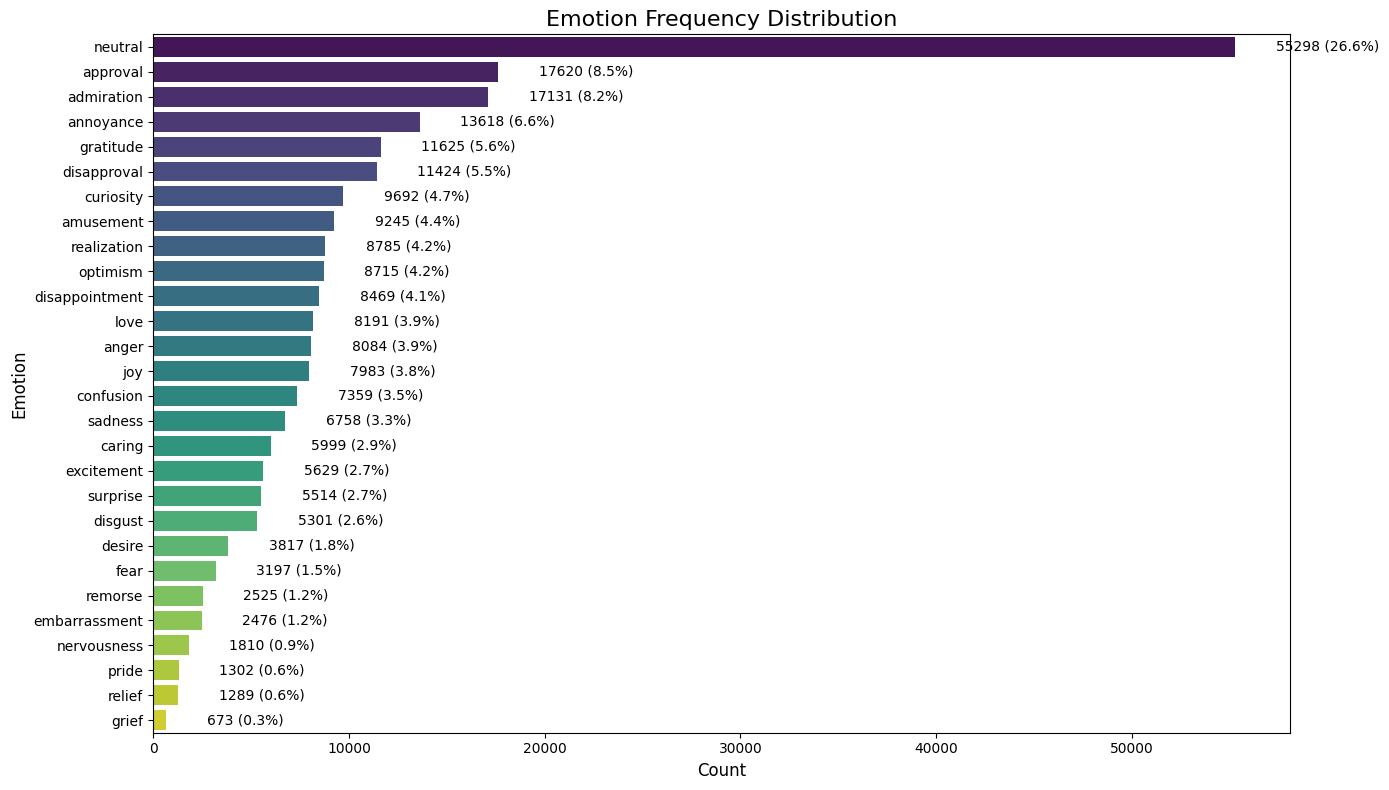


Emotion Frequency Table:
       Emotion  Count  Percentage
       neutral  55298       26.61
      approval  17620        8.48
    admiration  17131        8.24
     annoyance  13618        6.55
     gratitude  11625        5.59
   disapproval  11424        5.50
     curiosity   9692        4.66
     amusement   9245        4.45
   realization   8785        4.23
      optimism   8715        4.19
disappointment   8469        4.08
          love   8191        3.94
         anger   8084        3.89
           joy   7983        3.84
     confusion   7359        3.54
       sadness   6758        3.25
        caring   5999        2.89
    excitement   5629        2.71
      surprise   5514        2.65
       disgust   5301        2.55
        desire   3817        1.84
          fear   3197        1.54
       remorse   2525        1.22
 embarrassment   2476        1.19
   nervousness   1810        0.87
         pride   1302        0.63
        relief   1289        0.62
         grief    673 

In [ ]:
# Label Distribution Analysis
print("\n" + "="*50)
print("Label Distribution Analysis")
print("="*50)

# Create a matrix of emotions
emotion_matrix = np.array(df['vector'].tolist())
emotion_counts = emotion_matrix.sum(axis=0)
emotion_freq = pd.Series(emotion_counts, index=emotion_columns).sort_values(ascending=False)

# Plot emotion frequency
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=emotion_freq.values, y=emotion_freq.index, palette="viridis")
plt.title('Emotion Frequency Distribution', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Emotion', fontsize=12)

# Add percentage annotations
total = len(df)
for i, v in enumerate(emotion_freq.values):
    ax.text(v + total*0.01, i, f'{v} ({v/total:.1%})', 
            color='black', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# Print frequency of each emotion
print("\nEmotion Frequency Table:")
emotion_freq_df = emotion_freq.reset_index()
emotion_freq_df.columns = ['Emotion', 'Count']
emotion_freq_df['Percentage'] = (emotion_freq_df['Count'] / total * 100).round(2)

print(emotion_freq_df.to_string(index=False))


Multi-Label Analysis


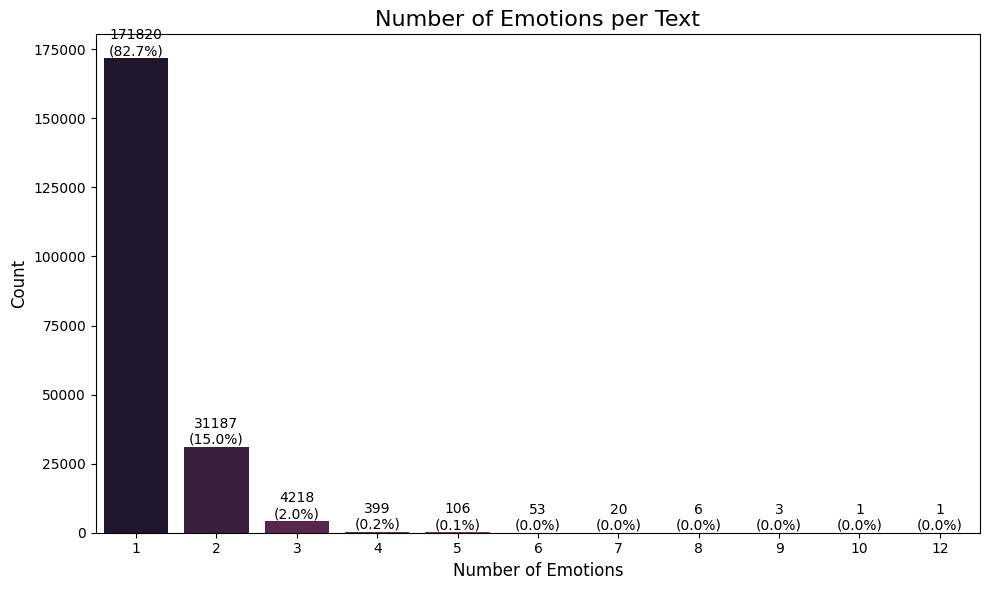

Texts with single emotion: 171820 (82.7%)
Maximum emotions in one text: 12


In [7]:
# Multi-Label Analysis
print("\n" + "="*50)
print("Multi-Label Analysis")
print("="*50)

# Number of labels per text
label_counts = emotion_matrix.sum(axis=1)
count_dist = pd.Series(label_counts).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=count_dist.index, y=count_dist.values, palette="rocket")
plt.title('Number of Emotions per Text', fontsize=16)
plt.xlabel('Number of Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add annotations
for i, v in enumerate(count_dist.values):
    plt.text(i, v + 1000, f'{v}\n({v/total:.1%})', 
             ha='center', color='black', fontsize=10)
plt.tight_layout()
plt.show()

print(f"Texts with single emotion: {count_dist[1]} ({count_dist[1]/total:.1%})")
print(f"Maximum emotions in one text: {label_counts.max()}")


Emotion Co-occurrence Analysis


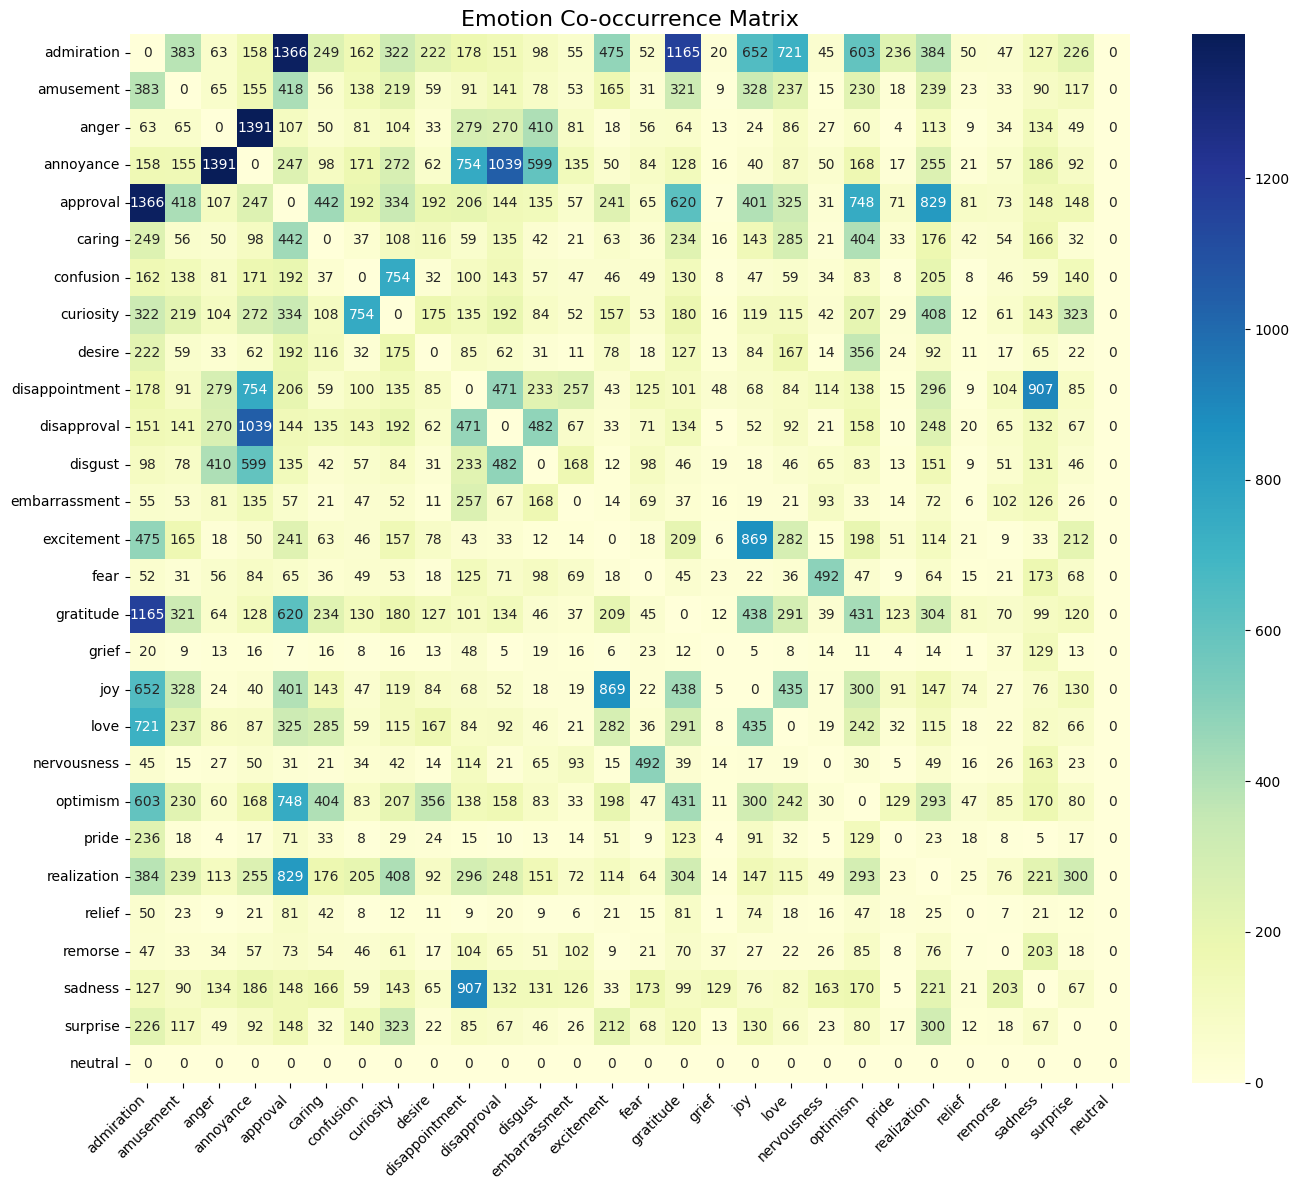


Top Co-occurring Emotion Pairs (Unique):
          Emotion1        Emotion2   Count
0            anger       annoyance  1391.0
1       admiration        approval  1366.0
2       admiration       gratitude  1165.0
3        annoyance     disapproval  1039.0
4   disappointment         sadness   907.0
5       excitement             joy   869.0
6         approval     realization   829.0
7        annoyance  disappointment   754.0
8        confusion       curiosity   754.0
9         approval        optimism   748.0
10      admiration            love   721.0
11      admiration             joy   652.0
12        approval       gratitude   620.0
13      admiration        optimism   603.0
14       annoyance         disgust   599.0


In [8]:
# Co-occurrence Analysis
print("\n" + "="*50)
print("Emotion Co-occurrence Analysis")
print("="*50)

# Create co-occurrence matrix
cooccurrence = emotion_matrix.T @ emotion_matrix
np.fill_diagonal(cooccurrence, 0)  # Remove self-counts

# Visualize the full matrix (keeping symmetry for visualization)
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=emotion_columns, 
            yticklabels=emotion_columns)
plt.title('Emotion Co-occurrence Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Get upper triangle only to avoid duplicate pairs
cooccurrence_df = pd.DataFrame(cooccurrence, 
                             columns=emotion_columns, 
                             index=emotion_columns)
mask = np.triu(np.ones(cooccurrence_df.shape), k=1).astype(bool)
stacked = cooccurrence_df.where(mask).stack().reset_index()
stacked.columns = ['Emotion1', 'Emotion2', 'Count']

# Filter and sort
top_pairs = stacked[stacked['Count'] > 0].sort_values('Count', ascending=False).head(15)

print("\nTop Co-occurring Emotion Pairs (Unique):")
print(top_pairs.reset_index(drop=True))

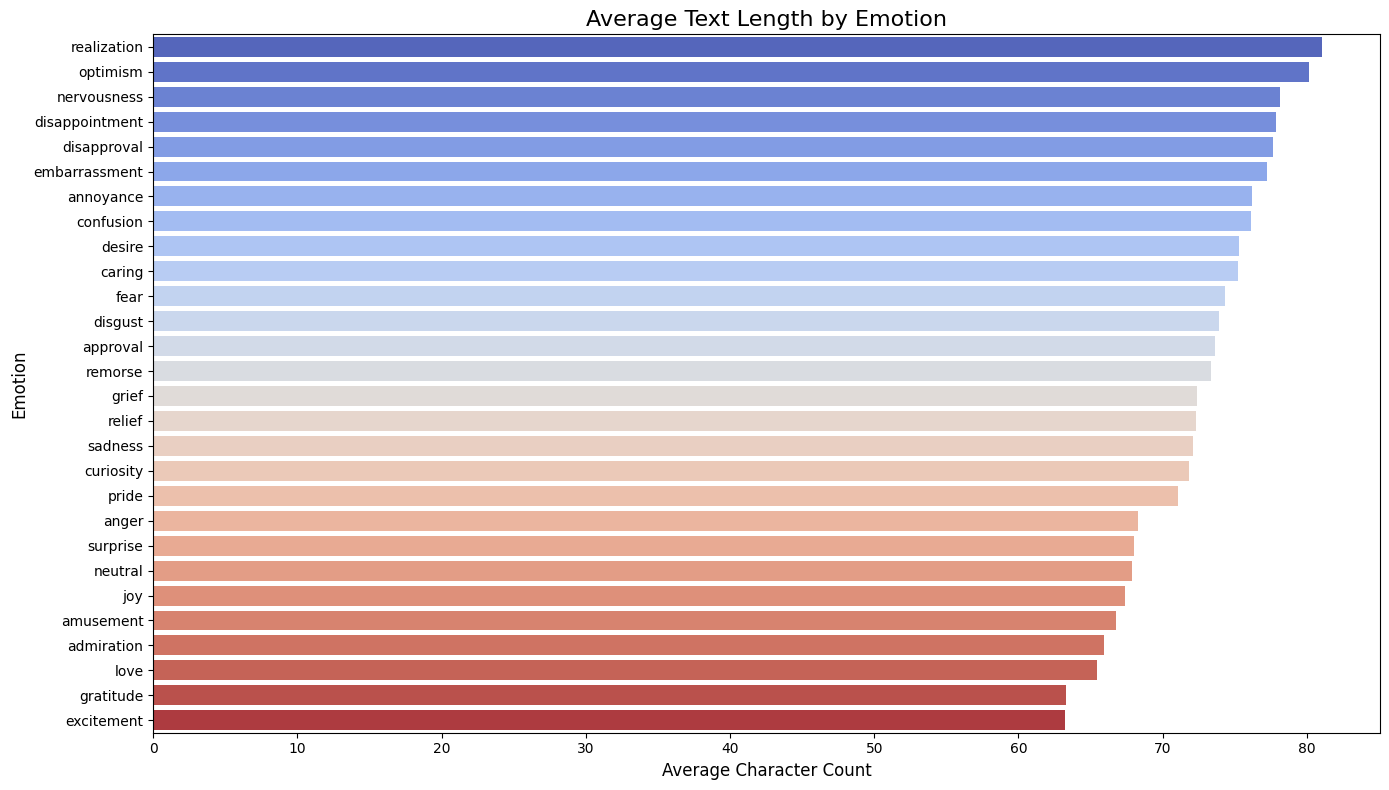


Emotions with longest texts:
           Emotion  Avg_Length
22     realization   81.016505
20        optimism   80.129891
19     nervousness   78.102210
9   disappointment   77.870587
10     disapproval   77.666317

Emotions with shortest texts:
       Emotion  Avg_Length
1    amusement   66.795890
0   admiration   65.911447
18        love   65.472470
15   gratitude   63.261849
13  excitement   63.199858


In [10]:
# Emotion Correlation with Text Length
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(14, 8))
emotion_lengths = []
for emotion in emotion_columns:
    lengths = df[df['vector'].apply(lambda x: x[emotion_columns.index(emotion)] == 1)]['text_length']
    emotion_lengths.append(lengths.mean())

length_df = pd.DataFrame({
    'Emotion': emotion_columns,
    'Avg_Length': emotion_lengths
}).sort_values('Avg_Length', ascending=False)

sns.barplot(x='Avg_Length', y='Emotion', data=length_df, palette='coolwarm')
plt.title('Average Text Length by Emotion', fontsize=16)
plt.xlabel('Average Character Count', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.tight_layout()
plt.show()

print("\nEmotions with longest texts:")
print(length_df.head(5))
print("\nEmotions with shortest texts:")
print(length_df.tail(5))

---
# 3.0 Text preprocessing
- Lowercasing
- Expanding contractions
- Expanding short forms 
- Removing punctuation, special characters, digits
- Tokenization
- Handling negations
- POS tagging
- Stemming and Lemmatization
- Removing stopwords
- Data augmentation such as paraphrasing and synonym replacement

In [ ]:
# Lowercase
df['text'] = df['text'].str.lower()

In [ ]:
# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

df['text'] = df['text'].apply(expand_contractions)
df['text'][:5]

0                                      that game hurt.
1     you do right, if you do not care then fuck them!
2                                   man i love reddit.
3    [name] was nowhere near them, he was by the fa...
4    right? considering it is such an important doc...
Name: text, dtype: object

In [ ]:
# Expand short forms
with open("shortform_dict.json", "r") as f:
    shortform_dict = json.load(f)

def expand_shortforms(text, shortform_dict):
    def replace(match):
        word = match.group(0)
        return shortform_dict.get(word.lower(), word)

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in shortform_dict.keys()) + r')\b', flags=re.IGNORECASE)
    return pattern.sub(replace, text)

df['text'] = df['text'].apply(expand_shortforms, shortform_dict=shortform_dict)
df['text'][:5]

0                                      that game hurt.
1     you do right, if you do not care then fuck them!
2                                   man i love reddit.
3    [name] was nowhere near them, he was by the fa...
4    right? considering it is such an important doc...
Name: text, dtype: object

In [ ]:
# Remove punctuation, special characters, digits, emojis, and extra whitespace
def clean_text(text):
    text = re.sub(r'\[name\]', '', text)  # Remove [NAME]
    # text = re.sub(r'\[.*?\]', '', text)  # Remove [NAME], [URL], etc.
    
    text = re.sub(r'[-—]', ' ', text) # Replace hyphens/dashes with spaces to avoid merged words
    
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces

    text = ' '.join(text.split())  # Clean whitespace
    return text

df['text'] = df['text'].apply(clean_text)

In [ ]:
# Tokenization
df['tokens'] = df['text'].apply(word_tokenize)
df['tokens'][:5]

0                                   [that, game, hurt]
1    [you, do, right, if, you, do, not, care, then,...
2                               [man, i, love, reddit]
3    [was, nowhere, near, them, he, was, by, the, f...
4    [right, considering, it, is, such, an, importa...
Name: tokens, dtype: object

In [ ]:
# Handle negations 
def handle_negations(tokens):
    negation_words = {"not", "no", "never", "n't", "neither", "nor"}
    new_tokens = []
    i = 0

    while i < len(tokens):
        if tokens[i] in negation_words and i + 1 < len(tokens):
            new_tokens.append(tokens[i] + "_" + tokens[i + 1])  # Merge negation with the next word
            i += 2 
        else:
            new_tokens.append(tokens[i])
            i += 1

    return new_tokens  

df['tokens'] = df['tokens'].apply(handle_negations)
df['tokens'][:5]

0                                   [that, game, hurt]
1    [you, do, right, if, you, do, not_care, then, ...
2                               [man, i, love, reddit]
3    [was, nowhere, near, them, he, was, by, the, f...
4    [right, considering, it, is, such, an, importa...
Name: tokens, dtype: object

In [ ]:
# Pos tagging
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()  
    tag_dict = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) 

In [ ]:
# Stemming and Lemmatization
stemmer = PorterStemmer()
df['stemmed'] = df['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)
df[['stemmed','lemmatized']][:5]

stemmed  \
0                                 [that, game, hurt]   
1  [you, do, right, if, you, do, not_car, then, f...   
2                             [man, i, love, reddit]   
3  [wa, nowher, near, them, he, wa, by, the, falcon]   
4  [right, consid, it, is, such, an, import, docu...   

                                          lemmatized  
0                                 [that, game, hurt]  
1  [you, do, right, if, you, do, not_care, then, ...  
2                             [man, i, love, reddit]  
3  [be, nowhere, near, them, he, be, by, the, fal...  
4  [right, consider, it, be, such, an, important,...

Lemmatized words are used for better accuracy and meaning matter.

- Lemmatization: Converts words to their base/dictionary form
- Stemming: Chops off word endings to get the root form

In [ ]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
df['filtered_tokens'] = df['lemmatized'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
df['filtered_tokens'][:5]

0                                         [game, hurt]
1                              [right, not_care, fuck]
2                                  [man, love, reddit]
3                              [nowhere, near, falcon]
4    [right, consider, important, document, know, d...
Name: filtered_tokens, dtype: object

In [ ]:
# Data augmentation: Synonym Replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word and len(synonym.split()) == 1:  # Only single-word synonyms
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(tokens, n=2):
    """Replace n random words with synonyms"""
    new_tokens = tokens.copy()
    valid_indices = [i for i, word in enumerate(tokens) if get_synonyms(word)]
    
    if not valid_indices or len(valid_indices) < n:
        return tokens  # Not enough replaceable words
    
    # Randomly select indices to replace
    indices_to_replace = random.sample(valid_indices, n)
    
    for idx in indices_to_replace:
        word = tokens[idx]
        synonyms = get_synonyms(word)
        if synonyms:
            new_tokens[idx] = random.choice(synonyms)
    
    return new_tokens

# Example of Synonym Replacement
df['augmented_tokens'] = df['filtered_tokens'].apply(lambda tokens: synonym_replacement(tokens, n=2))
df['augmented_tokens'][:5]

0                                      [halting, harm]
1                              [proper, not_care, bed]
2                                 [homo, fuck, reddit]
3                              [nowhere, near, falcon]
4    [right, consider, important, document, acknowl...
Name: augmented_tokens, dtype: object

In [ ]:
df

text       emotion  \
0                                          that game hurt     [sadness]   
1          you do right if you do not care then fuck them     [neutral]   
2                                       man i love reddit        [love]   
3              was nowhere near them he was by the falcon     [neutral]   
4       right considering it is such an important docu...   [gratitude]   
...                                                   ...           ...   
207809  well i am glad you are out of all that now how...         [joy]   
207810                                     everyone likes        [love]   
207811  well when you have imported about a gazillion ...      [caring]   
207812                                 that looks amazing  [admiration]   
207813  the fda has plenty to criticize but like here ...       [anger]   

                                                   vector  \
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
...                                                   ...   
207809  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
207810  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
207811  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
207812  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
207813  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                   tokens  \
0                                      [that, game, hurt]   
1       [you, do, right, if, you, do, not_care, then, ...   
2                                  [man, i, love, reddit]   
3       [was, nowhere, near, them, he, was, by, the, f...   
4       [right, considering, it, is, such, an, importa...   
...                                                   ...   
207809  [well, i, am, glad, you, are, out, of, all, th...   
207810                                  [everyone, likes]   
207811  [well, when, you, have, imported, about, a, ga...   
207812                             [that, looks, amazing]   
207813  [the, fda, has, plenty, to, criticize, but, li...   

                                                  stemmed  \
0                                      [that, game, hurt]   
1       [you, do, right, if, you, do, not_car, then, f...   
2                                  [man, i, love, reddit]   
3       [wa, nowher, near, them, he, wa, by, the, falcon]   
4       [right, consid, it, is, such, an, import, docu...   
...                                                   ...   
207809  [well, i, am, glad, you, are, out, of, all, th...   
207810                                    [everyon, like]   
207811  [well, when, you, have, import, about, a, gazi...   
207812                                 [that, look, amaz]   
207813  [the, fda, ha, plenti, to, critic, but, like, ...   

                                               lemmatized  \
0                                      [that, game, hurt]   
1       [you, do, right, if, you, do, not_care, then, ...   
2                                  [man, i, love, reddit]   
3       [be, nowhere, near, them, he, be, by, the, fal...   
4       [right, consider, it, be, such, an, important,...   
...                                                   ...   
207809  [well, i, be, glad, you, be, out, of, all, tha...   
207810                                   [everyone, like]   
207811  [well, when, you, have, import, about, a, gazi...   
207812                                [that, look, amaze]   
207813  [the, fda, have, plenty, to, criticize, but, l...   

                                          filtered_tokens  \
0                                            [game, hurt]   
1                                 [right, not_care, fuck]   
2                                    


Text Analysis


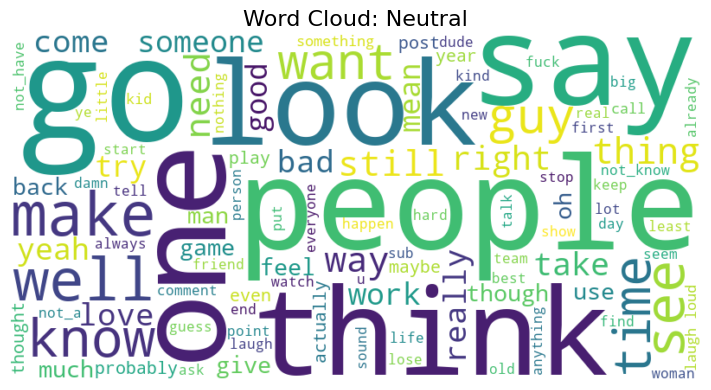

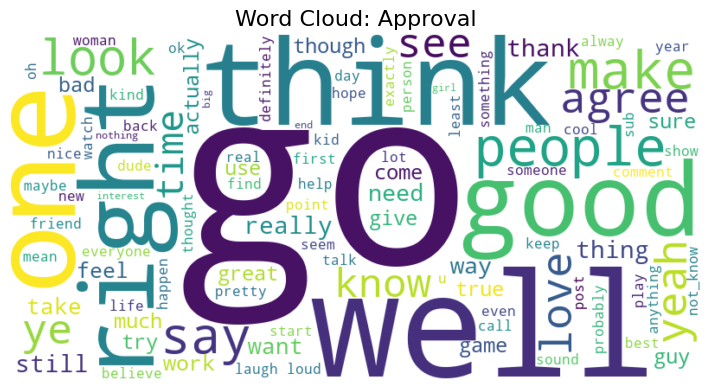

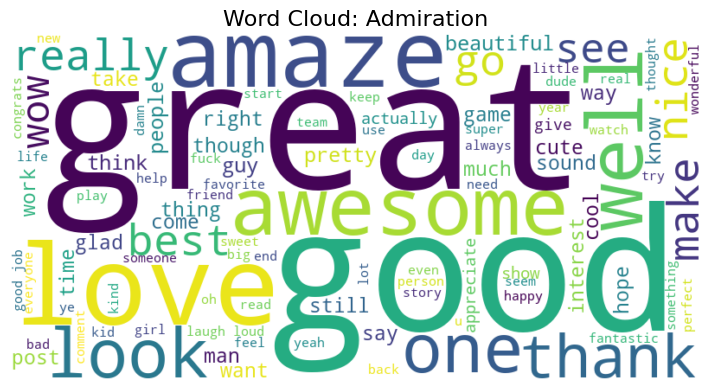

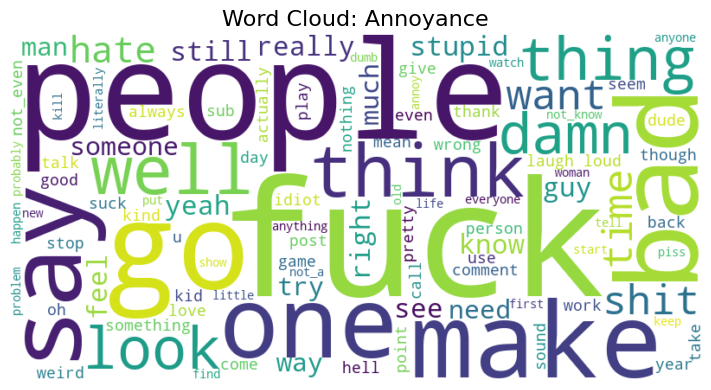

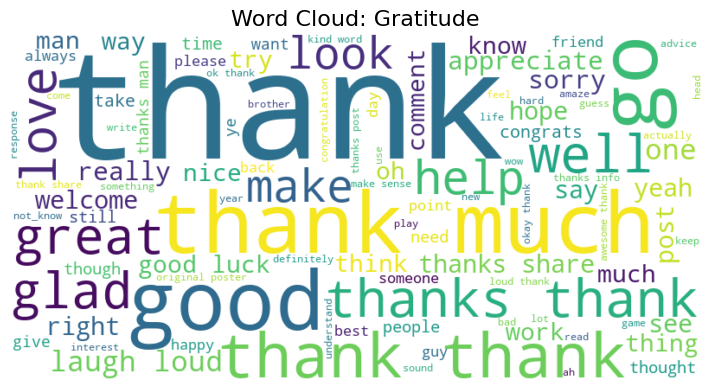

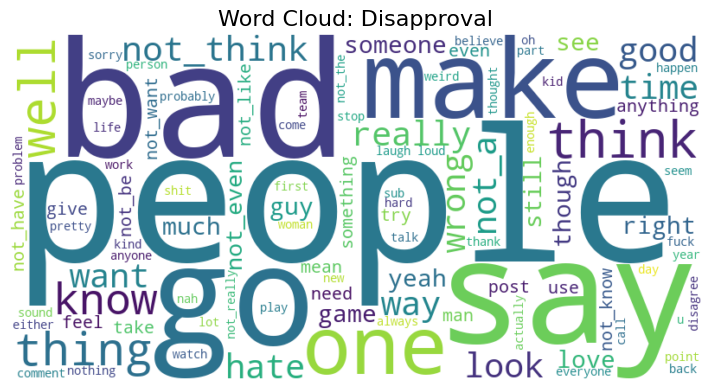

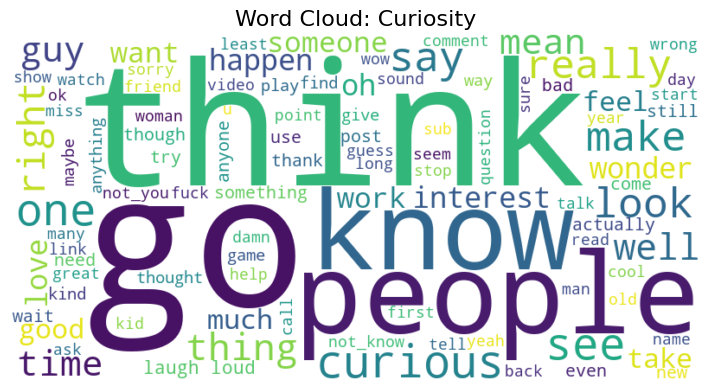

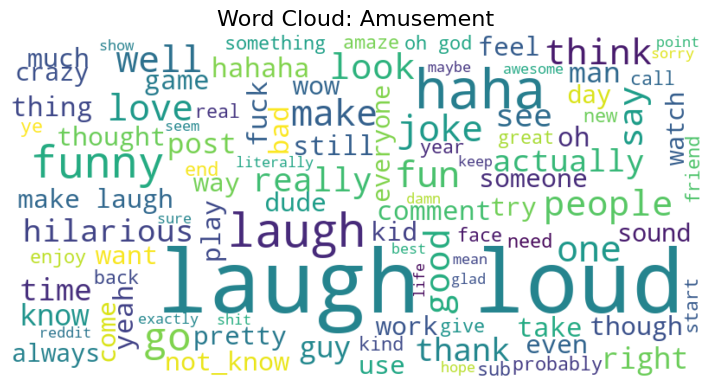

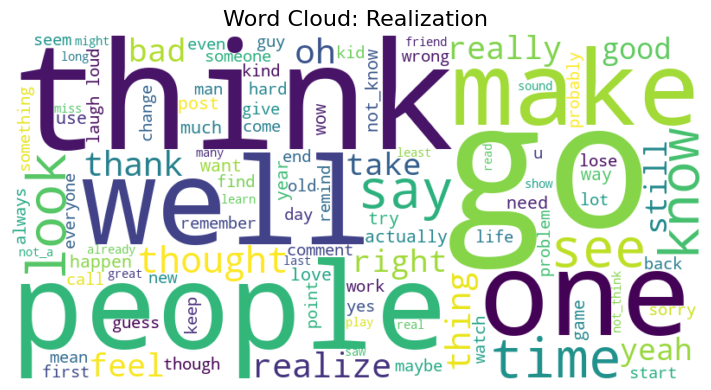

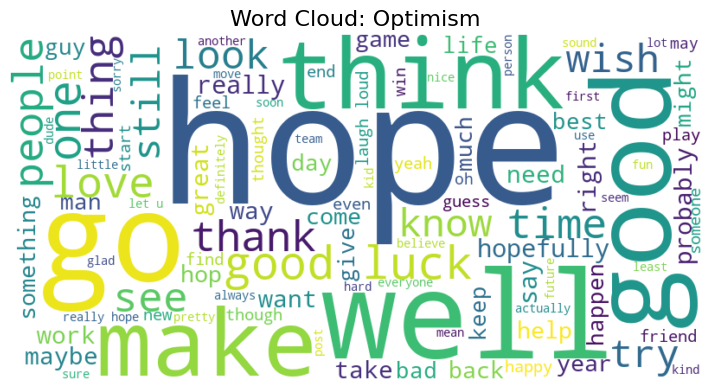

In [ ]:
print("\n" + "="*50)
print("Text Analysis")
print("="*50)

# Count the frequency of each emotion (sum column-wise)
emotion_freq = pd.DataFrame(df['vector'].tolist(), columns=emotion_columns).sum().sort_values(ascending=False)

def generate_word_cloud_from_tokens(emotion, max_words=100):
    # Filter rows where this emotion is present
    emotion_rows = df[df['vector'].apply(lambda x: x[emotion_columns.index(emotion)] == 1)]
    
    # Flatten list of tokens into one big list
    all_tokens = [token for tokens in emotion_rows['filtered_tokens'] for token in tokens]
    text = " ".join(all_tokens)  # Combine into one string

    # Generate and plot word cloud
    plt.figure(figsize=(8, 4))
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud: {emotion.capitalize()}', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate for top 5 and bottom 5 emotions
for emotion in emotion_freq.index[:10]:
    generate_word_cloud_from_tokens(emotion)

---
# 4.0 Data splitting
Using Iterative Stratified Splitting
- 70% Train set
- 15% Test set
- 15% Validation set

In [3]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Configuration
RARE_EMOTIONS = ['grief', 'pride', 'relief', 'nervousness', 'remorse', 'embarrassment', 'fear', 'desire']
AUGMENTATION_FACTOR = 5
MIN_SAMPLES = 500
NEUTRAL_DOWNSAMPLE_RATIO = 0.5

# Load and Prepare Labels
y = np.array(df['vector'].tolist())
neutral_idx = emotion_columns.index('neutral')

# Identify samples that are only labeled as neutral
only_neutral_mask = (
    np.all(y[:, :neutral_idx] == 0, axis=1) &
    np.all(y[:, neutral_idx + 1:] == 0, axis=1) &
    (y[:, neutral_idx] == 1)
)

# Downsample pure neutral samples 
neutral_indices = np.where(only_neutral_mask)[0]
non_neutral_indices = np.where(~only_neutral_mask)[0]
keep_count = int(len(neutral_indices) * NEUTRAL_DOWNSAMPLE_RATIO)
selected_neutral = np.random.choice(neutral_indices, keep_count, replace=False)

# Combine and shuffle
balanced_indices = np.concatenate([non_neutral_indices, selected_neutral])
np.random.shuffle(balanced_indices)
y_balanced = y[balanced_indices]
balanced_dataset_indices = np.arange(len(y_balanced)) 

In [4]:
# Iterative Stratified Splitting (Train/Val/Test)

# First split: Train (70%) / Temp (30%)
stratifier_train_temp = IterativeStratification(
    n_splits=2, order=2, sample_distribution_per_fold=[0.7, 0.3]
)
train_balanced_idx, temp_balanced_idx = next(stratifier_train_temp.split(balanced_dataset_indices, y_balanced))

# Second split: Val (15%) / Test (15%) from Temp
stratifier_val_test = IterativeStratification(
    n_splits=2, order=2, sample_distribution_per_fold=[0.5, 0.5]
)
temp_sub_indices = np.arange(len(temp_balanced_idx))
val_balanced_sub_idx, test_balanced_sub_idx = next(
    stratifier_val_test.split(temp_sub_indices, y_balanced[temp_balanced_idx])
)

# Map back to original indices
train_indices = balanced_indices[train_balanced_idx]
val_indices = balanced_indices[temp_balanced_idx[val_balanced_sub_idx]]
test_indices = balanced_indices[temp_balanced_idx[test_balanced_sub_idx]]

In [5]:
# Create DataFrames for Each Split
train_df = df.iloc[train_indices].copy()
val_df = df.iloc[val_indices].copy()
test_df = df.iloc[test_indices].copy()

# Extract emotion labels for readability
def vector_to_labels(vector):
    return [emotion_columns[i] for i, val in enumerate(vector) if val == 1]

for df_split in [train_df, val_df, test_df]:
    df_split['emotion'] = df_split['vector'].apply(vector_to_labels)
    df_split['sample_weight'] = 1.0
    df_split['is_augmented'] = True

In [6]:
# Data augmentation: Synonym Replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word and len(synonym.split()) == 1:  # Only single-word synonyms
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(tokens, n=2):
    """Replace n random words with synonyms"""
    new_tokens = tokens.copy()
    valid_indices = [i for i, word in enumerate(tokens) if get_synonyms(word)]
    
    if not valid_indices or len(valid_indices) < n:
        return tokens  # Not enough replaceable words
    
    # Randomly select indices to replace
    indices_to_replace = random.sample(valid_indices, n)
    
    for idx in indices_to_replace:
        word = tokens[idx]
        synonyms = get_synonyms(word)
        if synonyms:
            new_tokens[idx] = random.choice(synonyms)
    
    return new_tokens

In [7]:
# Data Augmentation: Synonym Replacement
augmented_samples = []

for _, row in train_df.iterrows():
    emotions = row['emotion']
    augment_rare = any(e in RARE_EMOTIONS for e in emotions)
    augment_non_neutral = 'neutral' not in emotions
    boost_factor = 1.5 if augment_rare else 1.2
    boost_count = AUGMENTATION_FACTOR if augment_rare else 1

    if augment_rare or augment_non_neutral:
        for _ in range(boost_count):
            n_replace = random.choice([1, 1, 2, 2, 3])
            aug_tokens = synonym_replacement(row['filtered_tokens'], n=n_replace)
            augmented_text = " ".join(aug_tokens)

            augmented_samples.append({
                'text': augmented_text,
                'filtered_tokens': aug_tokens,
                'vector': row['vector'],
                'emotion': row['emotion'],
                'sample_weight': row['sample_weight'] * boost_factor,
                'is_augmented': True
            })

# Add augmented samples to training data

if augmented_samples:
    augmented_df = pd.DataFrame(augmented_samples)
    train_df = pd.concat([train_df, augmented_df], ignore_index=True) 

In [8]:
# Extract Data for Modeling
X_train = train_df['filtered_tokens'].values
X_val = val_df['filtered_tokens'].values
X_test = test_df['filtered_tokens'].values

y_train = np.array(train_df['vector'].tolist())
y_val = np.array(val_df['vector'].tolist())
y_test = np.array(test_df['vector'].tolist())

train_weights = train_df['sample_weight'].values

In [9]:
# Print Distribution Summary
def print_distribution(y, name, total_samples):
    print(f"\n{name} Set Distribution ({total_samples} samples):")
    for i, emotion in enumerate(emotion_columns):
        count = np.sum(y[:, i])
        print(f"- {emotion}: {count} ({count/total_samples*100:.2f}%)")

print_distribution(y_train, "Augmented Train", len(X_train))
print_distribution(y_val, "Validation", len(X_val))
print_distribution(y_test, "Test", len(X_test))


Augmented Train Set Distribution (119269 samples):
- admiration: 11070 (9.28%)
- amusement: 5826 (4.88%)
- anger: 5118 (4.29%)
- annoyance: 8666 (7.27%)
- approval: 11224 (9.41%)
- caring: 3960 (3.32%)
- confusion: 4652 (3.90%)
- curiosity: 6276 (5.26%)
- desire: 6870 (5.76%)
- disappointment: 5862 (4.91%)
- disapproval: 7222 (6.06%)
- disgust: 3636 (3.05%)
- embarrassment: 4458 (3.74%)
- excitement: 3614 (3.03%)
- fear: 5754 (4.82%)
- gratitude: 7540 (6.32%)
- grief: 1212 (1.02%)
- joy: 5170 (4.33%)
- love: 5282 (4.43%)
- nervousness: 3258 (2.73%)
- optimism: 6054 (5.08%)
- pride: 2346 (1.97%)
- realization: 5714 (4.79%)
- relief: 2322 (1.95%)
- remorse: 4548 (3.81%)
- sadness: 4986 (4.18%)
- surprise: 3524 (2.95%)
- neutral: 8295 (6.95%)

Validation Set Distribution (62967 samples):
- admiration: 5996 (9.52%)
- amusement: 3236 (5.14%)
- anger: 2830 (4.49%)
- annoyance: 4767 (7.57%)
- approval: 6167 (9.79%)
- caring: 2100 (3.34%)
- confusion: 2575 (4.09%)
- curiosity: 3392 (5.39%)
- 

---
# 5.0 Feature Extraction
- Bag of Words
- TF-IDF
- N-gram
- Word Embeddings such as Word2Vec, FastText

### 5.1 Traditional Feature Extraction

In [10]:
# Convert tokens back to text for BoW, TF-IDF, and N-grams
X_train_texts = [' '.join(tokens) for tokens in X_train]
X_val_texts = [' '.join(tokens) for tokens in X_val]
X_test_texts = [' '.join(tokens) for tokens in X_test]

In [11]:
# Function to plot WordCloud
def plot_word_cloud(feature_names, feature_scores, title):
    # Create a dictionary for word frequencies
    word_freq = dict(zip(feature_names, feature_scores))
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq) # Generate WordCloud
    
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

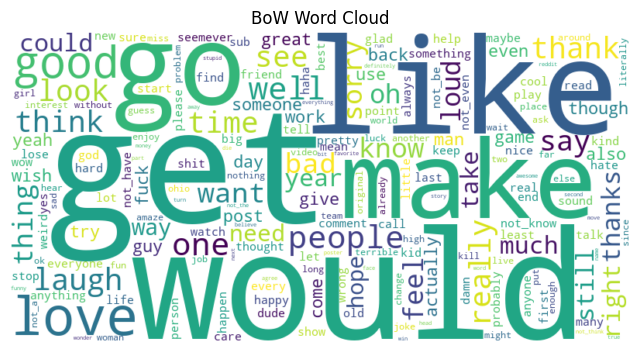

In [16]:
# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train_texts)
X_val_bow = bow_vectorizer.transform(X_val_texts)
X_test_bow = bow_vectorizer.transform(X_test_texts)

# Visualizing BoW using Word Cloud
bow_feature_names = bow_vectorizer.get_feature_names_out()
bow_scores = X_train_bow.toarray().sum(axis=0)  # Word frequency

plot_word_cloud(bow_feature_names, bow_scores, title="BoW Word Cloud")

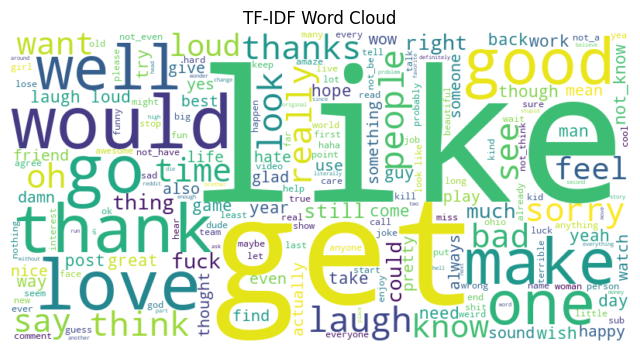

In [13]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=8000,ngram_range=(1, 2), min_df=5, max_df=0.7)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_val_tfidf = tfidf_vectorizer.transform(X_val_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

# Visualizing TF-IDF using Word Cloud
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(X_train_tfidf.mean(axis=0)).flatten()

plot_word_cloud(tfidf_feature_names, tfidf_scores, title="TF-IDF Word Cloud")

### 5.2 Pretrained Word Embeddings

In [10]:
# Word Embeddings: Word2Vec using pre-trained Google News vectors
w2v_vectors = gensim.downloader.load('word2vec-google-news-300')

In [11]:
# Word Embeddings: FastText using English pre-trained FastText (300d)
fasttext_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

---
# 6.0 Models Development
## 6.1 Machine Learning models
- Naive Bayes
- XGBoost

In [17]:
# Function to train and evaluate Machine Learning model 
def train_ML_model(model, X_train, X_val, y_train, y_val, X_test, y_test, model_name):
    print(f"=== {model_name} ===")
    
    # Wrap model for multi-label classification
    ml_model = OneVsRestClassifier(model)
    
    # Train on training set
    ml_model.fit(X_train, y_train)

    # Evaluate on Validation Set 
    y_val_pred = ml_model.predict(X_val)
    val_hamming = hamming_loss(y_val, y_val_pred)
    val_jaccard = jaccard_score(y_val, y_val_pred, average='samples')
    print(f"Validation Hamming Loss: {val_hamming:.4f}")
    print(f"Validation Jaccard Score: {val_jaccard:.4f}")
    
    # Final Evaluation on Test Set
    y_test_pred = ml_model.predict(X_test)
    test_hamming = hamming_loss(y_test, y_test_pred)
    test_jaccard = jaccard_score(y_test, y_test_pred, average='samples')
    test_f1 = f1_score(y_test, y_test_pred, average='micro')
    
    print(f"\nTest Hamming Loss: {test_hamming:.4f}")
    print(f"Test Jaccard Score: {test_jaccard:.4f}")
    print(f"Test Micro F1-Score: {test_f1:.4f}")
    
    # Classification Report
    print(f"\nClassification Report ({model_name}):\n")
    print(classification_report(y_test, y_test_pred, target_names=emotion_columns, zero_division=0))
    
    # Plot F1 scores per emotion
    f1_scores = []
    for i, emotion in enumerate(emotion_columns):
        f1 = f1_score(y_test[:, i], y_test_pred[:, i])
        f1_scores.append(f1)
    
    plt.figure(figsize=(7, 5))
    sns.barplot(y=emotion_columns, x=f1_scores, palette="viridis")
    plt.title(f"F1 Scores per Emotion - {model_name}")
    plt.xlabel("F1 Score")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return ml_model

### 6.1.1 Naive Bayes

=== Naive Bayes with BoW ===
Validation Hamming Loss: 0.0465
Validation Jaccard Score: 0.1516

Test Hamming Loss: 0.0464
Test Jaccard Score: 0.1533
Test Micro F1-Score: 0.2467

Classification Report (Naive Bayes with BoW):

                precision    recall  f1-score   support

    admiration       0.55      0.33      0.42      5996
     amusement       0.62      0.46      0.53      3236
         anger       0.36      0.14      0.20      2829
     annoyance       0.25      0.09      0.13      4766
      approval       0.28      0.07      0.11      6167
        caring       0.28      0.10      0.15      2099
     confusion       0.38      0.11      0.17      2576
     curiosity       0.30      0.07      0.12      3392
        desire       0.22      0.15      0.18      1336
disappointment       0.22      0.06      0.09      2964
   disapproval       0.27      0.09      0.13      3999
       disgust       0.33      0.11      0.16      1856
 embarrassment       0.19      0.11      0.14  

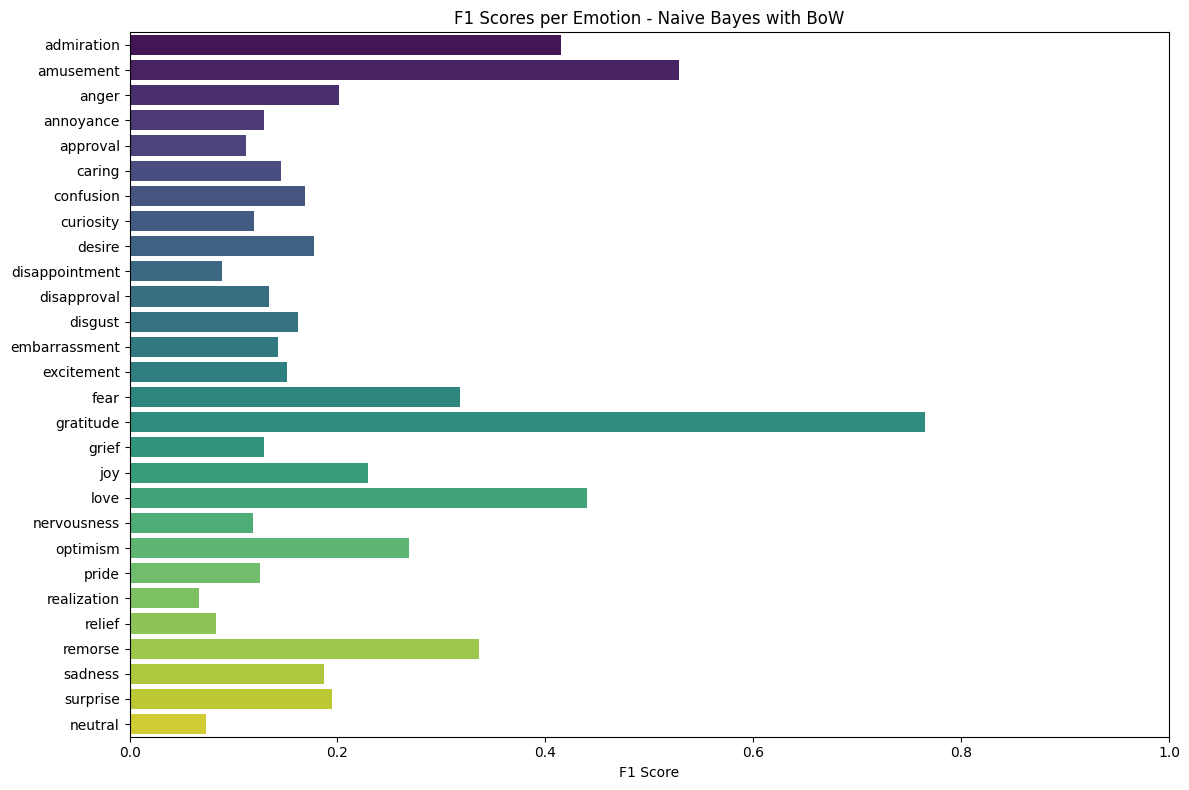

=== Naive Bayes with TF-IDF ===
Validation Hamming Loss: 0.0429
Validation Jaccard Score: 0.0411

Test Hamming Loss: 0.0427
Test Jaccard Score: 0.0427
Test Micro F1-Score: 0.0788

Classification Report (Naive Bayes with TF-IDF):

                precision    recall  f1-score   support

    admiration       0.74      0.08      0.15      5996
     amusement       0.71      0.12      0.21      3236
         anger       0.50      0.00      0.01      2829
     annoyance       0.27      0.00      0.00      4766
      approval       0.64      0.01      0.01      6167
        caring       0.68      0.01      0.02      2099
     confusion       0.80      0.00      0.01      2576
     curiosity       0.81      0.01      0.02      3392
        desire       0.47      0.04      0.07      1336
disappointment       0.33      0.00      0.00      2964
   disapproval       0.45      0.00      0.00      3999
       disgust       0.94      0.01      0.02      1856
 embarrassment       0.50      0.01      

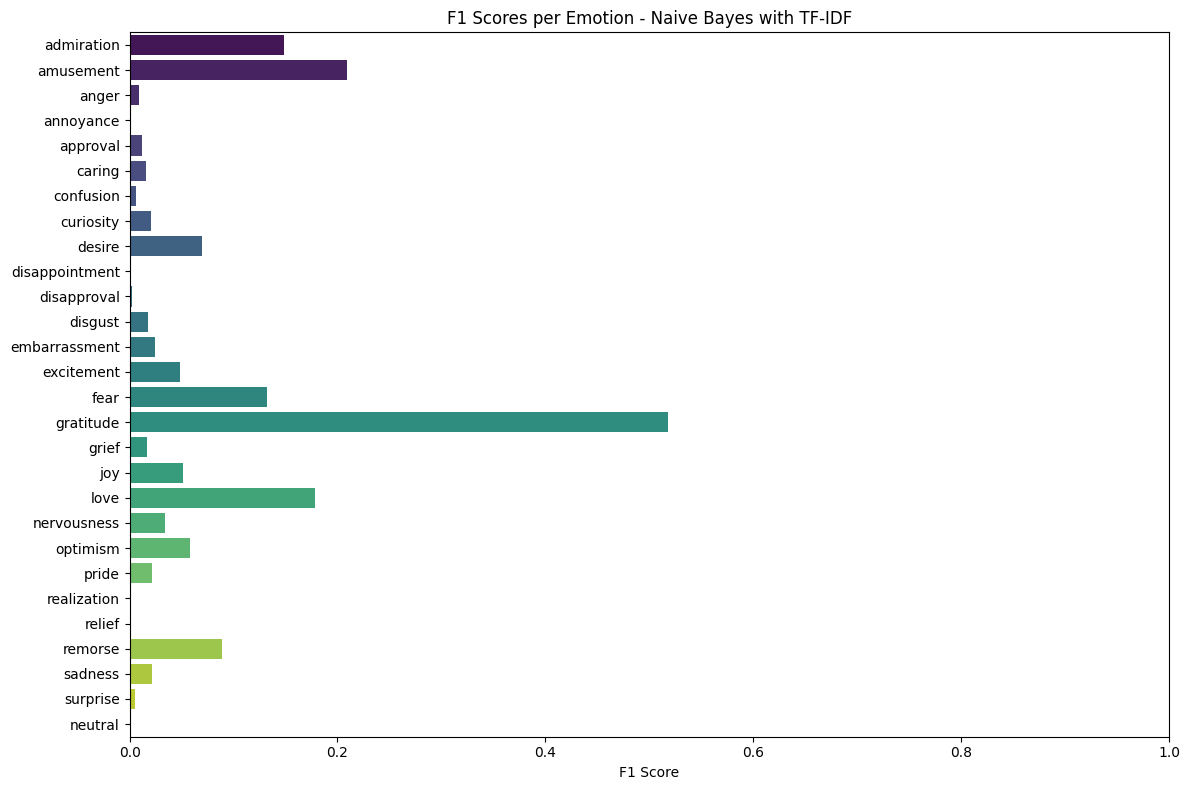

In [31]:
# Naive Bayes model
nb_model = MultinomialNB()

#  Train and evaluate Naive Bayes model
nb_bow = train_ML_model(nb_model, X_train_bow, X_val_bow, y_train, y_val, X_test_bow, y_test, model_name="Naive Bayes with BoW")
nb_tfidf = train_ML_model(nb_model, X_train_tfidf, X_val_tfidf, y_train, y_val, X_test_tfidf, y_test, model_name="Naive Bayes with TF-IDF")

### 6.1.2 XGBoost

=== XGBoost with BoW ===
Validation Hamming Loss: 0.0410
Validation Jaccard Score: 0.1545

Test Hamming Loss: 0.0409
Test Jaccard Score: 0.1536
Test Micro F1-Score: 0.2572

Classification Report (XGBoost with BoW):

                precision    recall  f1-score   support

    admiration       0.66      0.27      0.39      5996
     amusement       0.62      0.56      0.59      3236
         anger       0.50      0.05      0.09      2829
     annoyance       0.43      0.02      0.03      4766
      approval       0.59      0.04      0.07      6167
        caring       0.43      0.05      0.09      2099
     confusion       0.58      0.10      0.17      2576
     curiosity       0.72      0.05      0.09      3392
        desire       0.45      0.19      0.27      1336
disappointment       0.57      0.03      0.05      2964
   disapproval       0.38      0.01      0.02      3999
       disgust       0.65      0.09      0.16      1856
 embarrassment       0.41      0.17      0.24       867

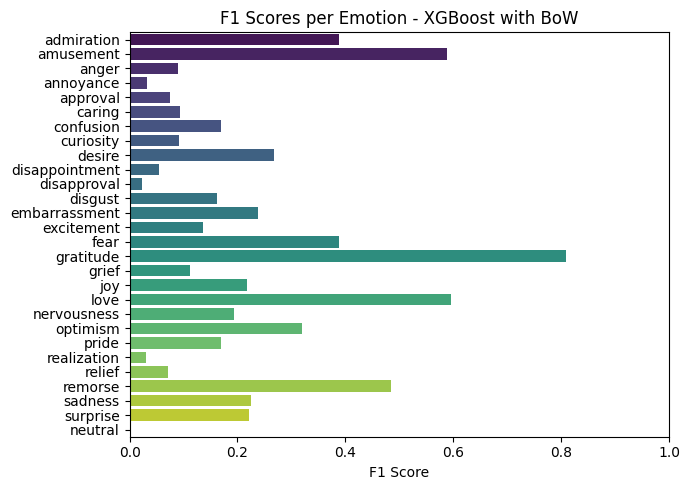

=== XGBoost with TF-IDF ===
Validation Hamming Loss: 0.0411
Validation Jaccard Score: 0.1606

Test Hamming Loss: 0.0410
Test Jaccard Score: 0.1592
Test Micro F1-Score: 0.2627

Classification Report (XGBoost with TF-IDF):

                precision    recall  f1-score   support

    admiration       0.66      0.31      0.42      5996
     amusement       0.63      0.51      0.56      3236
         anger       0.52      0.09      0.15      2829
     annoyance       0.34      0.01      0.02      4766
      approval       0.57      0.04      0.08      6167
        caring       0.44      0.06      0.10      2099
     confusion       0.58      0.10      0.18      2576
     curiosity       0.72      0.05      0.10      3392
        desire       0.42      0.19      0.26      1336
disappointment       0.55      0.03      0.06      2964
   disapproval       0.38      0.01      0.03      3999
       disgust       0.65      0.09      0.16      1856
 embarrassment       0.40      0.17      0.24    

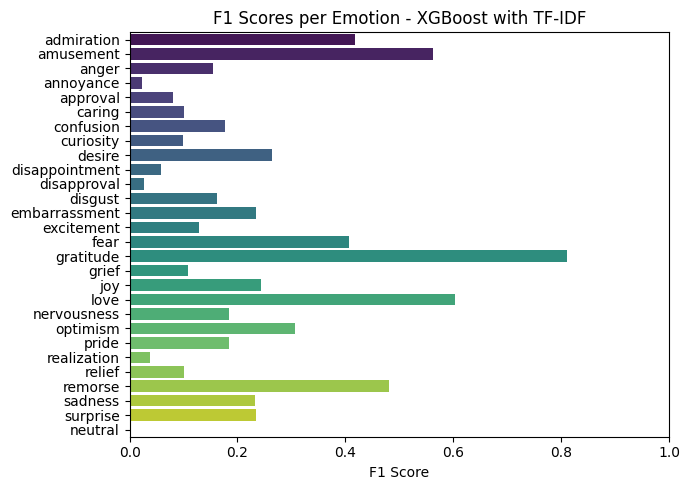

In [18]:
# XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic')

#  Train and evaluate XGBoost model
xgb_bow = train_ML_model(xgb_model, X_train_bow, X_val_bow, y_train, y_val, X_test_bow, y_test, model_name="XGBoost with BoW")
xgb_tfidf = train_ML_model(xgb_model, X_train_tfidf, X_val_tfidf, y_train, y_val, X_test_tfidf, y_test, model_name="XGBoost with TF-IDF")

=== XGBoost with BoW ===
Validation Hamming Loss: 0.0408
Validation Jaccard Score: 0.1498

Test Hamming Loss: 0.0407
Test Jaccard Score: 0.1486
Test Micro F1-Score: 0.2516

Classification Report (XGBoost with BoW):

                precision    recall  f1-score   support

    admiration       0.65      0.30      0.41      5996
     amusement       0.63      0.52      0.57      3236
         anger       0.55      0.05      0.10      2829
     annoyance       0.46      0.02      0.04      4766
      approval       0.61      0.04      0.07      6167
        caring       0.46      0.05      0.09      2099
     confusion       0.65      0.07      0.13      2576
     curiosity       0.78      0.05      0.09      3392
        desire       0.50      0.10      0.17      1336
disappointment       0.63      0.03      0.05      2964
   disapproval       0.43      0.01      0.02      3999
       disgust       0.69      0.09      0.16      1856
 embarrassment       0.52      0.10      0.16       867

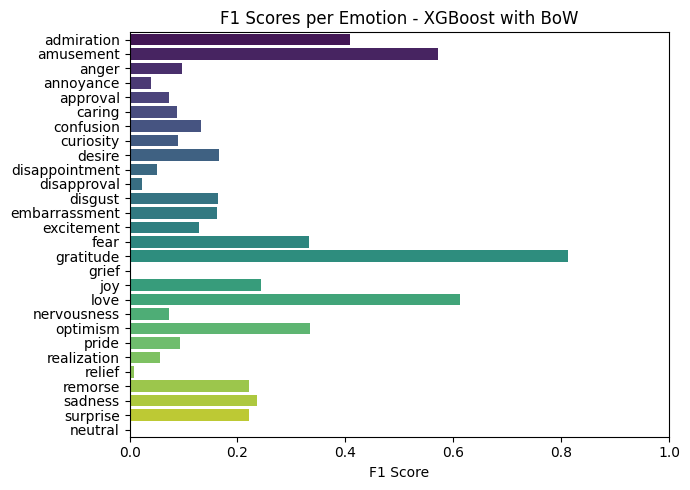

=== XGBoost with TF-IDF ===
Validation Hamming Loss: 0.0411
Validation Jaccard Score: 0.1525

Test Hamming Loss: 0.0410
Test Jaccard Score: 0.1523
Test Micro F1-Score: 0.2537

Classification Report (XGBoost with TF-IDF):

                precision    recall  f1-score   support

    admiration       0.66      0.32      0.43      5996
     amusement       0.64      0.52      0.57      3236
         anger       0.54      0.08      0.14      2829
     annoyance       0.39      0.02      0.04      4766
      approval       0.57      0.04      0.07      6167
        caring       0.44      0.05      0.09      2099
     confusion       0.60      0.09      0.15      2576
     curiosity       0.73      0.05      0.10      3392
        desire       0.49      0.10      0.17      1336
disappointment       0.61      0.03      0.06      2964
   disapproval       0.42      0.01      0.02      3999
       disgust       0.60      0.10      0.17      1856
 embarrassment       0.50      0.09      0.15    

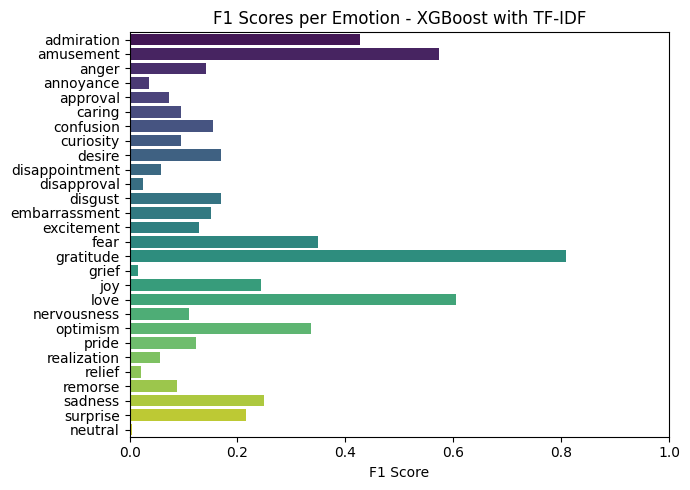

In [14]:
# XGBoost model
xgb_model = XGBClassifier(objective='binary:logistic')

#  Train and evaluate XGBoost model
xgb_bow = train_ML_model(xgb_model, X_train_bow, X_val_bow, y_train, y_val, X_test_bow, y_test, model_name="XGBoost with BoW")
xgb_tfidf = train_ML_model(xgb_model, X_train_tfidf, X_val_tfidf, y_train, y_val, X_test_tfidf, y_test, model_name="XGBoost with TF-IDF")

In [17]:
# XGBoost with class weighting
class WeightedXGBClassifier(XGBClassifier):
    def fit(self, X, y, **kwargs):
        # Calculate class weights for current binary task
        total_negative = (y == 0).sum()
        total_positive = (y == 1).sum()
        
        # Handle edge cases
        if total_positive == 0:
            self.scale_pos_weight = 1.0
        else:
            self.scale_pos_weight = total_negative / total_positive
            
        # Update model parameters
        self.set_params(scale_pos_weight=self.scale_pos_weight)
        return super().fit(X, y, **kwargs)

=== XGBoost (Weighted) with BoW ===
Validation Hamming Loss: 0.1323
Validation Jaccard Score: 0.2135

Test Hamming Loss: 0.1326
Test Jaccard Score: 0.2120
Test Micro F1-Score: 0.2856

Classification Report (XGBoost (Weighted) with BoW):

                precision    recall  f1-score   support

    admiration       0.40      0.69      0.50      5996
     amusement       0.51      0.78      0.62      3236
         anger       0.22      0.58      0.32      2829
     annoyance       0.17      0.50      0.26      4766
      approval       0.18      0.46      0.26      6167
        caring       0.12      0.53      0.20      2099
     confusion       0.14      0.45      0.22      2576
     curiosity       0.09      0.65      0.16      3392
        desire       0.12      0.65      0.20      1336
disappointment       0.12      0.42      0.18      2964
   disapproval       0.17      0.48      0.25      3999
       disgust       0.16      0.55      0.24      1856
 embarrassment       0.08      0.

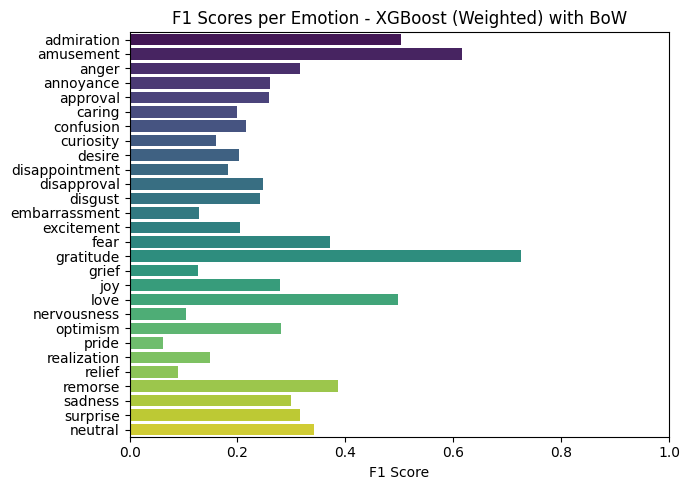

=== XGBoost (Weighted) with TF-IDF ===
Validation Hamming Loss: 0.1295
Validation Jaccard Score: 0.2136

Test Hamming Loss: 0.1297
Test Jaccard Score: 0.2121
Test Micro F1-Score: 0.2852

Classification Report (XGBoost (Weighted) with TF-IDF):

                precision    recall  f1-score   support

    admiration       0.38      0.70      0.49      5996
     amusement       0.52      0.77      0.62      3236
         anger       0.22      0.57      0.32      2829
     annoyance       0.17      0.47      0.25      4766
      approval       0.18      0.44      0.25      6167
        caring       0.12      0.52      0.20      2099
     confusion       0.15      0.45      0.22      2576
     curiosity       0.09      0.65      0.16      3392
        desire       0.13      0.62      0.21      1336
disappointment       0.12      0.41      0.18      2964
   disapproval       0.17      0.46      0.24      3999
       disgust       0.15      0.53      0.23      1856
 embarrassment       0.07  

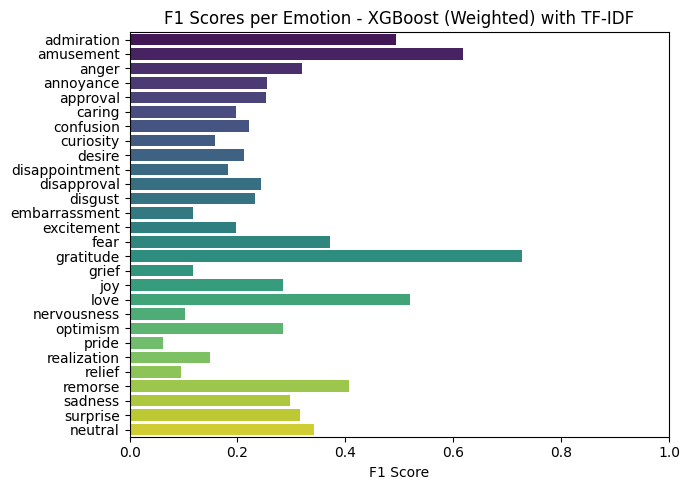

In [18]:
# XGBoost with class weighting
xgb_model = WeightedXGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

# Train and evaluate XGBoost model with class weighting
xgb_weighted_bow = train_ML_model(xgb_model, X_train_bow, X_val_bow, y_train, y_val, X_test_bow, y_test, 
                        model_name="XGBoost (Weighted) with BoW")
xgb_weighted_tfidf = train_ML_model(xgb_model, X_train_tfidf, X_val_tfidf, y_train, y_val, X_test_tfidf, y_test, 
                          model_name="XGBoost (Weighted) with TF-IDF")

In [35]:
# Compare Machine learning models
models = {
    "NB-BoW": nb_bow,
    "NB-TFIDF": nb_tfidf,
    "XGB-BoW": xgb_bow,
    "XGB-TFIDF": xgb_tfidf,
    "XGB-Weighted-BoW": xgb_weighted_bow,   
    "XGB-Weighted-TFIDF": xgb_weighted_tfidf
}

# Create comparison table
results = []
for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)  # Evaluate all on same features
    results.append({
        "Model": name,
        "Hamming Loss": hamming_loss(y_test, y_pred),
        "Jaccard Score": jaccard_score(y_test, y_pred, average='samples'),
        "Micro F1": f1_score(y_test, y_pred, average='micro')
    })

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values("Micro F1", ascending=False))


Model Comparison:
                Model  Hamming Loss  Jaccard Score  Micro F1
5  XGB-Weighted-TFIDF      0.129357       0.214469  0.285796
3           XGB-TFIDF      0.041032       0.157567  0.261335
4    XGB-Weighted-BoW      0.148288       0.075165  0.105943
1            NB-TFIDF      0.042712       0.042684  0.078787
2             XGB-BoW      0.048036       0.004526  0.009413
0              NB-BoW      0.045967       0.001528  0.003144


## 6.2 Deep Learning models
- CNN
- BiLSTM


In [12]:
# Prepare labels (multi-label format)
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(train_df['emotion'])
y_val_mlb = mlb.transform(val_df['emotion'])
y_test_mlb = mlb.transform(test_df['emotion'])
num_classes = len(mlb.classes_)

In [13]:
# Tokenization and padding for deep learning models
max_words = 10000
max_len = 100

# Use joined text for tokenization
X_train_texts = train_df['filtered_tokens'].apply(' '.join)
X_val_texts = val_df['filtered_tokens'].apply(' '.join)
X_test_texts = test_df['filtered_tokens'].apply(' '.join)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_texts)

X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_val_seq = tokenizer.texts_to_sequences(X_val_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [14]:
# Function to create embedding matrix
def create_embedding_matrix(word_index, embedding_vectors, max_words, embedding_dim=300):
    embedding_matrix = np.zeros((max_words, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_words:  # Only include words within vocabulary size
            if word in embedding_vectors:
                embedding_matrix[i] = embedding_vectors[word]
            else:
                embedding_matrix[i] = np.random.normal(loc=0.0, scale=0.6, size=(embedding_dim,))
    return embedding_matrix

# Create embedding matrices with max_words parameter
embedding_matrix_w2v = create_embedding_matrix(tokenizer.word_index, w2v_vectors, max_words)
embedding_matrix_ft = create_embedding_matrix(tokenizer.word_index, fasttext_vectors, max_words)

In [15]:
# Function to find optimal per-emotion thresholds using validation set
def optimize_thresholds(model, X_val, y_val, emotion_columns):
    y_val_pred = model.predict(X_val, verbose=0)
    thresholds = np.linspace(0.1, 0.9, 50)
    best_thresholds = []
    
    for i, emotion in enumerate(emotion_columns):
        # Skip if no positive samples
        if np.sum(y_val[:, i]) == 0:
            best_thresholds.append(0.5)
            continue
            
        best_f1 = 0
        best_thresh = 0.5
        
        for thresh in thresholds:
            preds = (y_val_pred[:, i] > thresh).astype(int)
            f1 = f1_score(y_val[:, i], preds, zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh
                
        best_thresholds.append(best_thresh)
        print(f"{emotion}: optimal threshold = {best_thresh:.3f} (F1={best_f1:.3f})")
    
    return np.array(best_thresholds)


In [16]:
# Function to train and evaluate deep learning models
def train_dl_model(model, X_train, y_train, X_val, y_val, X_test, y_test, 
                   model_name, emotion_columns, sample_weights=None, 
                   epochs=15, batch_size=128, tune_thresholds=True):
    print(f"=== {model_name} ===")
    
    # Callbacks configuration
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,                  # Stops if no improvement for 3 epochs
            restore_best_weights=True    # Restores the best model weights
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,                 # Reduces learning rate by half 
            patience=2,                 # Triggers if no improvement for 2 epochs  
            min_lr=1e-6                 # Sets a minimum learning rate
        )
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        sample_weight=sample_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    # Predict on test set
    y_test_pred = model.predict(X_test, verbose=0)
    
    # Apply optimal thresholds if tuning enabled
    if tune_thresholds and emotion_columns is not None:
        thresholds = optimize_thresholds(model, X_val, y_val, emotion_columns)
        y_test_pred_binary = np.zeros_like(y_test_pred)
        for i, thresh in enumerate(thresholds):
            y_test_pred_binary[:, i] = (y_test_pred[:, i] > thresh).astype(int)
    else:
        # Default threshold (0.5 for all emotions)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
    
    # Calculate metrics
    test_hamming = hamming_loss(y_test, y_test_pred_binary)
    test_jaccard = jaccard_score(y_test, y_test_pred_binary, average='samples')
    test_f1 = f1_score(y_test, y_test_pred_binary, average='micro')
    
    print(f"\n=== {model_name} ===")
    print(f"Test Hamming Loss: {test_hamming:.4f}")
    print(f"Test Jaccard Score: {test_jaccard:.4f}")
    print(f"Test Micro F1-Score: {test_f1:.4f}")
    
    # Classification report
    if emotion_columns is not None:
        print(f"\nClassification Report ({model_name}):\n")
        print(classification_report(
            y_test, y_test_pred_binary, 
            target_names=emotion_columns, 
            zero_division=0
        ))
        
        # Plot F1 scores per emotion
        f1_scores = []
        for i in range(len(emotion_columns)):
            f1 = f1_score(y_test[:, i], y_test_pred_binary[:, i])
            f1_scores.append(f1)
        
        plt.figure(figsize=(7, 5))
        sns.barplot(y=emotion_columns, x=f1_scores, palette="viridis")
        plt.title(f"F1 Scores per Emotion - {model_name}")
        plt.xlabel("F1 Score")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()
    
    # Plot training history
    plt.figure(figsize=(14, 5))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    # AUC plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f'{model_name} - AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return model, history

In [17]:
# Function to create Focal Loss to handle class imbalane
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fn(y_true, y_pred):
        # Avoid NaN issues with safe clipping
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Calculate binary cross entropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        
        # Calculate focal loss components
        p_t = tf.exp(-bce)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        focal_loss = alpha_t * tf.pow(1 - p_t, gamma) * bce
        
        # Reduce mean while preserving batch dimension
        return tf.reduce_mean(focal_loss, axis=-1)
    
    return focal_loss_fn

### 6.2.1 CNN

In [18]:
# CNN model 
def cnn_model(embedding_matrix, embedding_dim=300, num_classes=28, use_focal_loss=False):
    model = Sequential([
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=embedding_matrix.shape[1],
            trainable=True
        ),
        Conv1D(256, 5, activation='relu', padding='same'),
        BatchNormalization(), 
        Dropout(0.3),
        Conv1D(256, 5, activation='relu', padding='same'),  
        Conv1D(128, 3, activation='relu', padding='same'),
        GlobalMaxPooling1D(),
        Dense(256, activation='relu'),  # Larger dense layer
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='sigmoid')
    ])
    
    # Configure loss and metrics
    if use_focal_loss:
        loss = focal_loss(alpha=0.5, gamma=1.0)
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc', multi_label=True),  
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    else:
        loss = 'binary_crossentropy'
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc', multi_label=True),  
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-4,
            clipnorm=1.0  # Gradient clipping for stability
        ),
        loss=loss,
        metrics=metrics
    )
    return model

=== CNN with Word2Vec Embeddings ===
Epoch 1/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 307s 321ms/step - accuracy: 0.9141 - auc: 0.5168 - loss: 0.3241 - precision: 0.0628 - recall: 0.0508 - val_accuracy: 0.9581 - val_auc: 0.7143 - val_loss: 0.1639 - val_precision: 0.7809 - val_recall: 0.0676 - learning_rate: 1.0000e-04
Epoch 2/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 316s 339ms/step - accuracy: 0.9555 - auc: 0.6807 - loss: 0.2000 - precision: 0.7413 - recall: 0.0597 - val_accuracy: 0.9584 - val_auc: 0.7758 - val_loss: 0.1493 - val_precision: 0.6526 - val_recall: 0.1165 - learning_rate: 1.0000e-04
Epoch 3/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 316s 339ms/step - accuracy: 0.9565 - auc: 0.7535 - loss: 0.1839 - precision: 0.6982 - recall: 0.1026 - val_accuracy: 0.9585 - val_auc: 0.7942 - val_loss: 0.1441 - val_precision: 0.6304 - val_recall: 0.1412 - learning_rate: 1.0000e-04
Epoch 4/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 317s 340ms/step - accuracy: 0.9572 - auc: 0.7908 - loss: 0.1750 - precision: 0.7046 - recall: 0.1294 

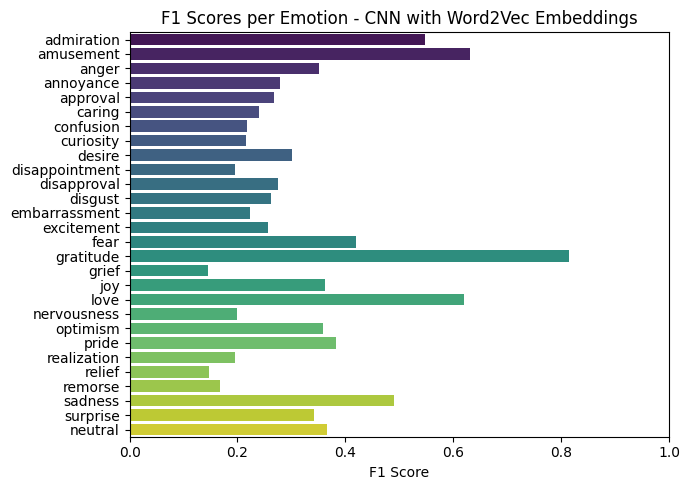

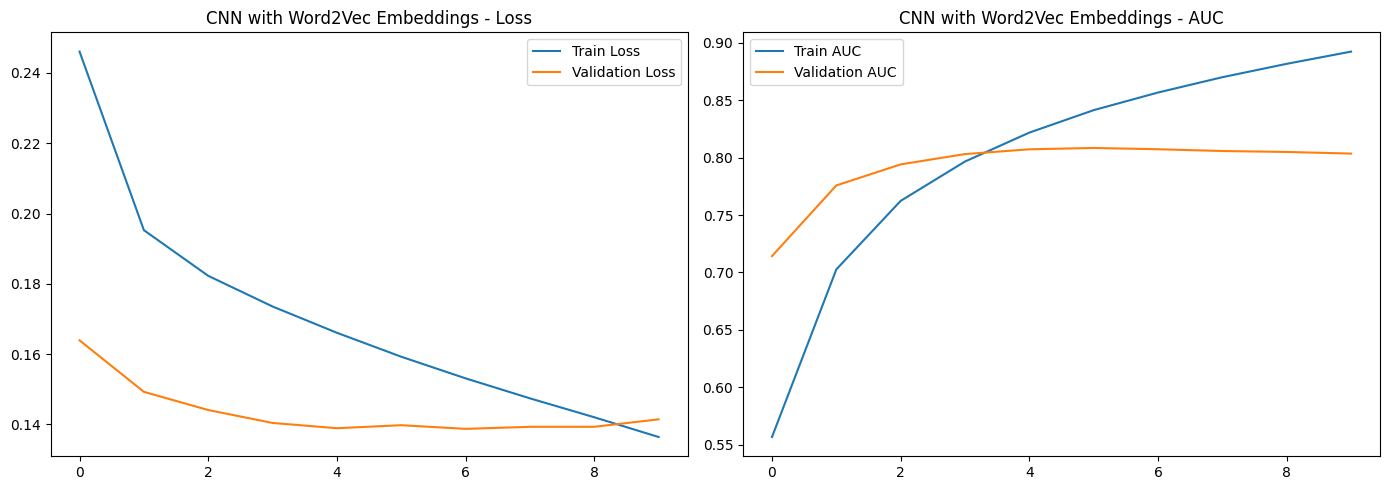

In [19]:
# Train and evaluate CNN model with Word2Vec embeddings (Binary Crossentropy)
cnn_w2v = cnn_model(embedding_matrix_w2v, embedding_dim=300, num_classes=len(emotion_columns),use_focal_loss=False)
cnn_w2v_model, cnn_w2v_history = train_dl_model(
    cnn_w2v,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="CNN with Word2Vec Embeddings",
    emotion_columns=emotion_columns,
    sample_weights=train_df['sample_weight'].values,
    epochs=15,
    batch_size=128
)

=== CNN (Focal Loss) with Word2Vec Embeddings ===
Epoch 1/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 300s 318ms/step - accuracy: 0.9144 - auc: 0.5106 - loss: 0.0742 - precision: 0.0590 - recall: 0.0467 - val_accuracy: 0.9579 - val_auc: 0.6964 - val_loss: 0.0418 - val_precision: 0.7872 - val_recall: 0.0616 - learning_rate: 1.0000e-04
Epoch 2/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 320s 343ms/step - accuracy: 0.9554 - auc: 0.6586 - loss: 0.0445 - precision: 0.7667 - recall: 0.0525 - val_accuracy: 0.9586 - val_auc: 0.7643 - val_loss: 0.0383 - val_precision: 0.7087 - val_recall: 0.1025 - learning_rate: 1.0000e-04
Epoch 3/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 307s 329ms/step - accuracy: 0.9562 - auc: 0.7334 - loss: 0.0412 - precision: 0.7155 - recall: 0.0855 - val_accuracy: 0.9588 - val_auc: 0.7889 - val_loss: 0.0365 - val_precision: 0.6698 - val_recall: 0.1288 - learning_rate: 1.0000e-04
Epoch 4/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 306s 329ms/step - accuracy: 0.9568 - auc: 0.7755 - loss: 0.0393 - precision: 0.7109 - re

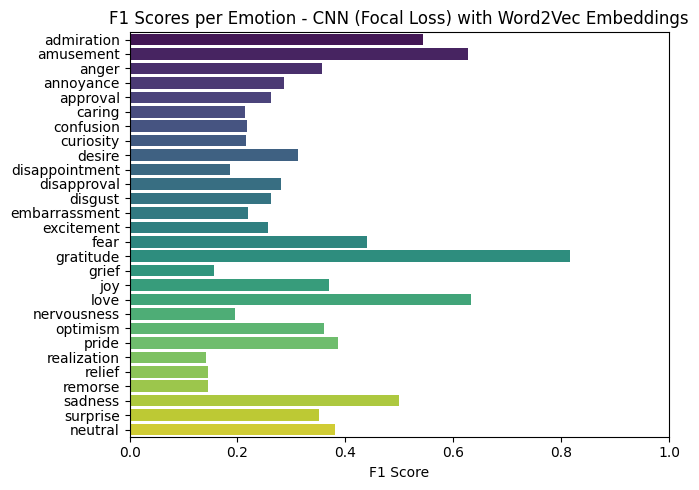

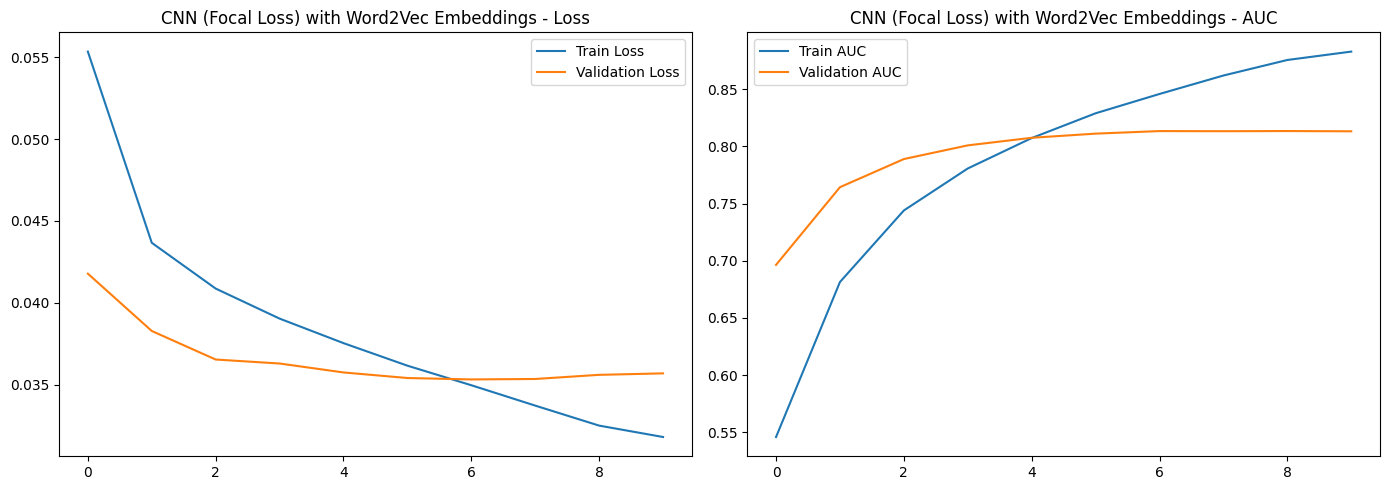

In [21]:
# Train and evaluate CNN model with Word2Vec embeddings (Focal loss to handle class imbalance)
cnn_focal_w2v = cnn_model(embedding_matrix_w2v, embedding_dim=300, num_classes=len(emotion_columns),use_focal_loss=True)
cnn_focal_w2v_model, cnn_focal_w2v_history = train_dl_model(
    cnn_focal_w2v,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="CNN (Focal Loss) with Word2Vec Embeddings",
    emotion_columns=emotion_columns,
    epochs=15,
    batch_size=128
)

=== CNN with FastText Embeddings ===
Epoch 1/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 300s 319ms/step - accuracy: 0.9161 - auc: 0.5163 - loss: 0.3153 - precision: 0.0574 - recall: 0.0401 - val_accuracy: 0.9579 - val_auc: 0.7198 - val_loss: 0.1623 - val_precision: 0.7855 - val_recall: 0.0615 - learning_rate: 1.0000e-04
Epoch 2/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 313s 336ms/step - accuracy: 0.9555 - auc: 0.6967 - loss: 0.1965 - precision: 0.7373 - recall: 0.0601 - val_accuracy: 0.9585 - val_auc: 0.7845 - val_loss: 0.1453 - val_precision: 0.6475 - val_recall: 0.1286 - learning_rate: 1.0000e-04
Epoch 3/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 318s 341ms/step - accuracy: 0.9570 - auc: 0.7833 - loss: 0.1769 - precision: 0.7059 - recall: 0.1167 - val_accuracy: 0.9588 - val_auc: 0.8015 - val_loss: 0.1401 - val_precision: 0.6376 - val_recall: 0.1472 - learning_rate: 1.0000e-04
Epoch 4/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 308s 331ms/step - accuracy: 0.9577 - auc: 0.8268 - loss: 0.1654 - precision: 0.7040 - recall: 0.1488 

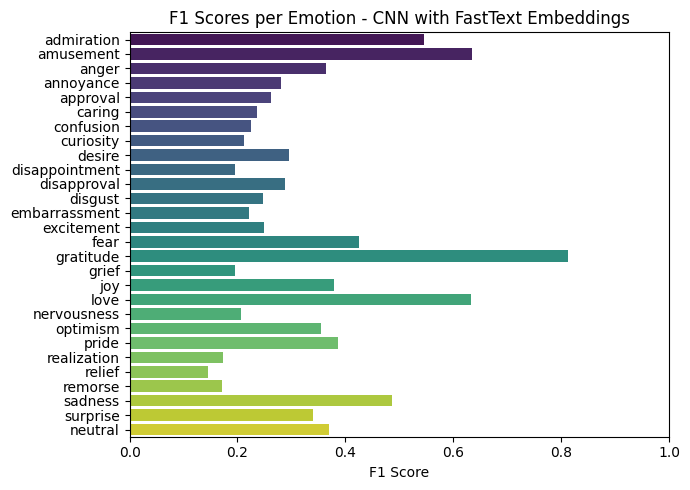

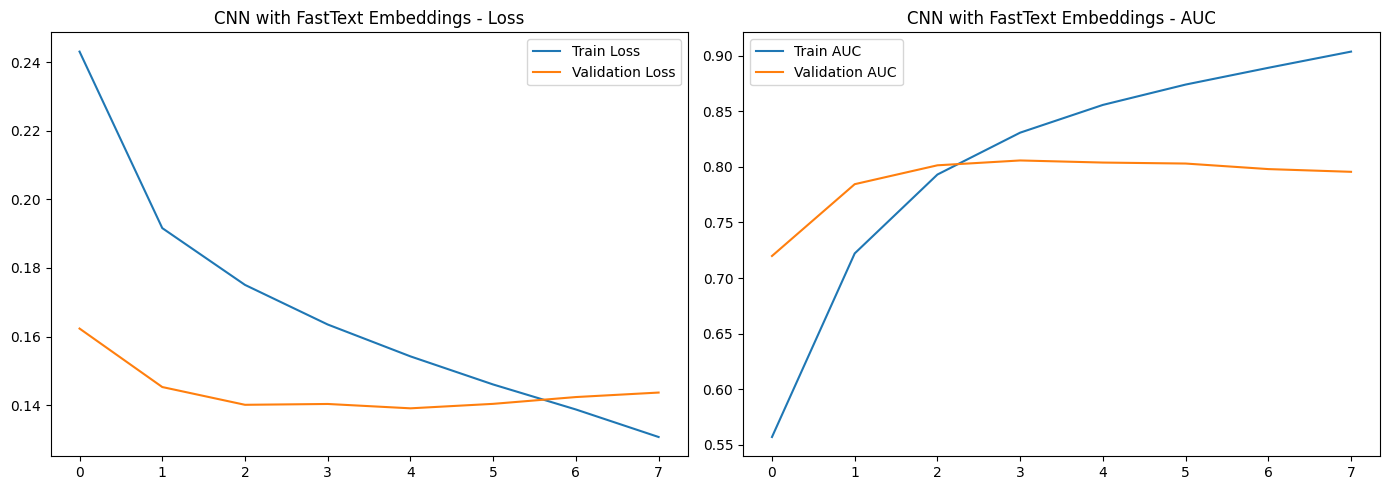

In [22]:
# Train and evaluate CNN model with FastText embeddings (Binary Crossentropy)
cnn_ft = cnn_model(embedding_matrix_ft, embedding_dim=300, num_classes=len(emotion_columns),use_focal_loss=False)
cnn_ft_model, cnn_ft_history = train_dl_model(
    cnn_ft,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="CNN with FastText Embeddings",
    emotion_columns=emotion_columns,
    sample_weights=train_df['sample_weight'].values,
    epochs=15,
    batch_size=128
)

=== CNN (Focal Loss) with FastText Embeddings ===
Epoch 1/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 282s 299ms/step - accuracy: 0.9246 - auc: 0.5142 - loss: 0.0697 - precision: 0.0618 - recall: 0.0364 - val_accuracy: 0.9576 - val_auc: 0.7160 - val_loss: 0.0422 - val_precision: 0.7999 - val_recall: 0.0496 - learning_rate: 1.0000e-04
Epoch 2/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 302s 324ms/step - accuracy: 0.9554 - auc: 0.6828 - loss: 0.0438 - precision: 0.7583 - recall: 0.0496 - val_accuracy: 0.9586 - val_auc: 0.7750 - val_loss: 0.0382 - val_precision: 0.6880 - val_recall: 0.1096 - learning_rate: 1.0000e-04
Epoch 3/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 299s 320ms/step - accuracy: 0.9563 - auc: 0.7686 - loss: 0.0398 - precision: 0.7115 - recall: 0.0909 - val_accuracy: 0.9589 - val_auc: 0.7973 - val_loss: 0.0360 - val_precision: 0.6619 - val_recall: 0.1354 - learning_rate: 1.0000e-04
Epoch 4/15
932/932 ━━━━━━━━━━━━━━━━━━━━ 300s 322ms/step - accuracy: 0.9573 - auc: 0.8124 - loss: 0.0373 - precision: 0.7086 - re

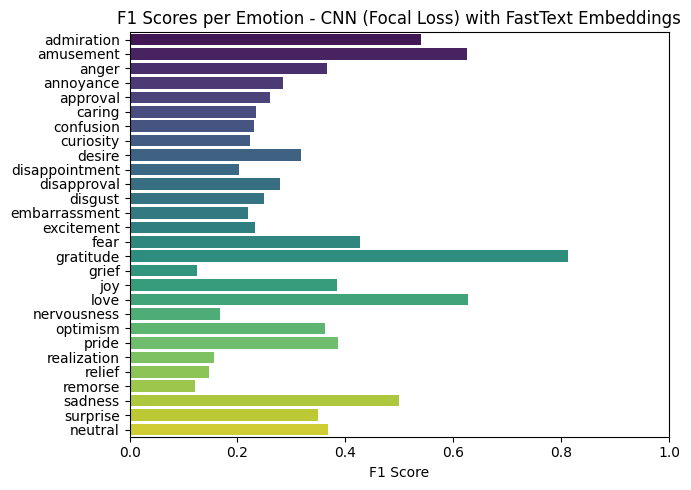

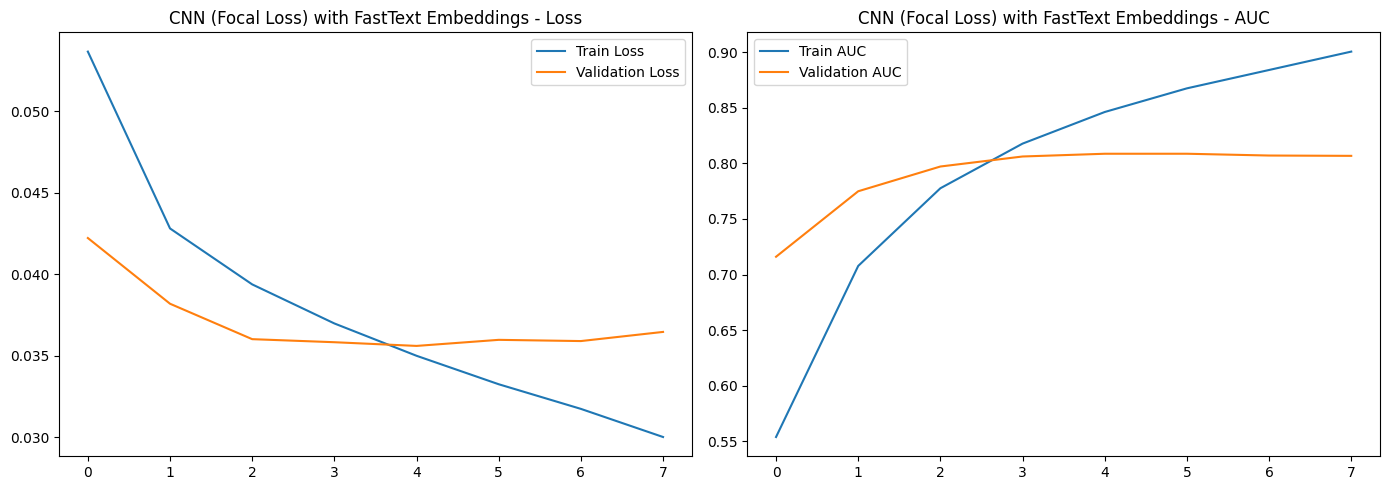

In [23]:
# Train and evaluate CNN model with FastText embeddings (Focal loss to handle class imbalance)
cnn_focal_ft = cnn_model(embedding_matrix_ft, embedding_dim=300, num_classes=len(emotion_columns),use_focal_loss=True)
cnn_focal_ft_model, cnn_focal_ft_history = train_dl_model(
    cnn_focal_ft,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="CNN (Focal Loss) with FastText Embeddings",
    emotion_columns=emotion_columns,
    epochs=15,
    batch_size=128
)

### 6.2.2 Bi-LSTM

In [18]:
# Bi-LSTM model without attention mechanism *Baseline*
def bilstm_model(embedding_matrix, embedding_dim=300, num_classes=28, use_focal_loss=False):
    model = Sequential([
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=embedding_matrix.shape[1],
            trainable=True
        ),
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh', 
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, activation='tanh', 
                           kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(num_classes, activation='sigmoid')  # Changed to sigmoid for multi-label
    ])
    
    # Configure loss and metrics
    if use_focal_loss:
        loss = focal_loss(alpha=0.5, gamma=1.0)
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc', multi_label=True),  
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    else:
        loss = 'binary_crossentropy'
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc', multi_label=True),  
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4, 
        clipnorm=1.0
    )
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

Embedding -> Bi-LSTM (128, L2 regularization) ->Batch Normalization + Dropout ->Bi-LSTM (64, L2 regularization) -> Batch Normalization + Dropout -> Dense -> SoftMax
- Regularization-heavy (L2, dropout, batch norm) to combat overfitting.
- No attention mechanism, relies purely on LSTM context.
- Baseline

=== BiLSTM with Word2Vec Embeddings ===
Epoch 1/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 459s 485ms/step - accuracy: 0.7410 - auc: 0.5133 - loss: 1.7061 - precision: 0.0519 - recall: 0.2626 - val_accuracy: 0.9565 - val_auc: 0.5152 - val_loss: 0.5888 - val_precision: 0.7240 - val_recall: 0.0197 - learning_rate: 1.0000e-04
Epoch 2/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 466s 500ms/step - accuracy: 0.9509 - auc: 0.5489 - loss: 0.4945 - precision: 0.1655 - recall: 0.0144 - val_accuracy: 0.9570 - val_auc: 0.6879 - val_loss: 0.2860 - val_precision: 0.9246 - val_recall: 0.0262 - learning_rate: 1.0000e-04
Epoch 3/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 470s 504ms/step - accuracy: 0.9539 - auc: 0.6070 - loss: 0.2875 - precision: 0.5257 - recall: 0.0303 - val_accuracy: 0.9575 - val_auc: 0.7325 - val_loss: 0.2040 - val_precision: 0.8394 - val_recall: 0.0446 - learning_rate: 1.0000e-04
Epoch 4/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 478s 513ms/step - accuracy: 0.9547 - auc: 0.6620 - loss: 0.2163 - precision: 0.6524 - recall: 0.04

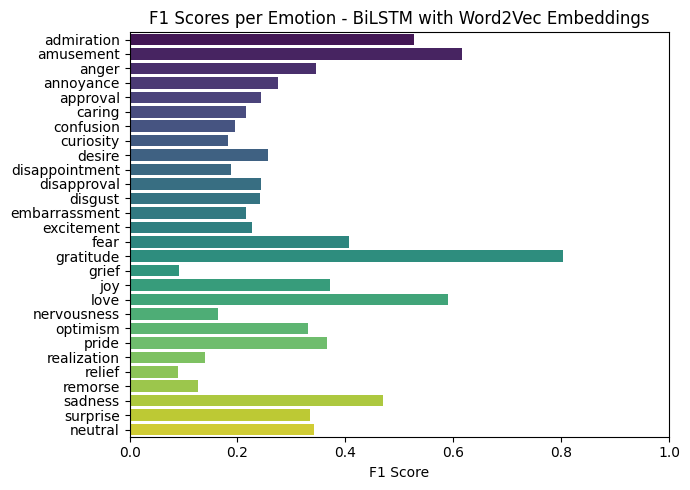

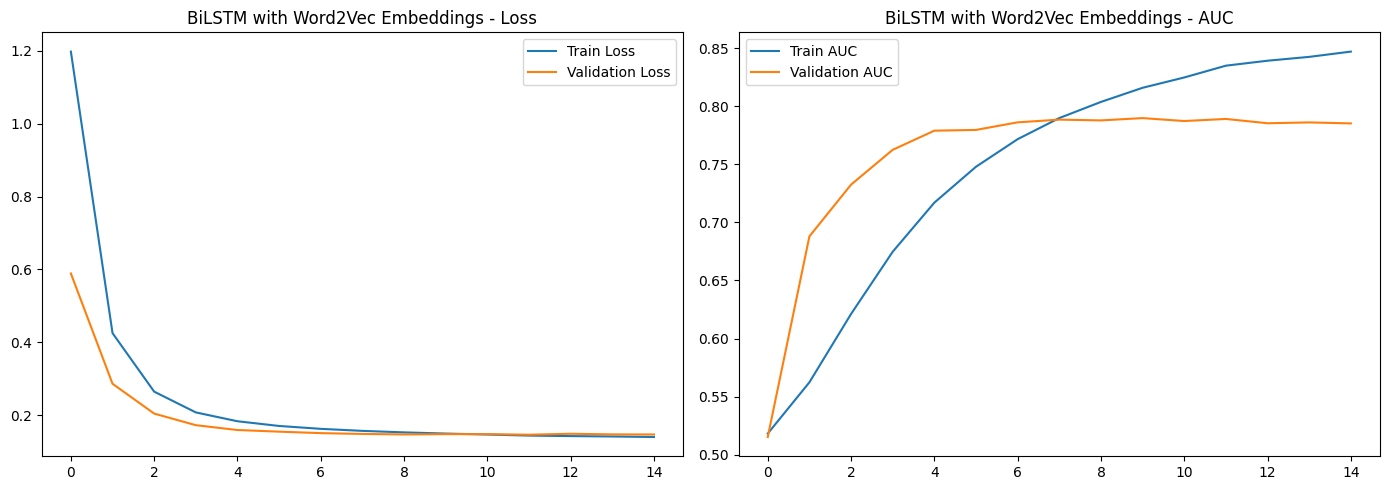

In [25]:
# Train and evaluate Bi-LSTM model with Word2Vec embeddings
bilstm_w2v = bilstm_model(embedding_matrix_w2v, embedding_dim=300, num_classes=len(emotion_columns), use_focal_loss=False  )
bilstm_model_w2v, bilstm_history_w2v = train_dl_model(
    bilstm_w2v,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM with Word2Vec Embeddings",
    emotion_columns=emotion_columns,
    epochs=20,
    batch_size=128
)

=== BiLSTM with FastText Embeddings ===
Epoch 1/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 847s 875ms/step - accuracy: 0.7305 - auc: 0.5037 - loss: 1.6809 - precision: 0.0491 - recall: 0.2606 - val_accuracy: 0.9533 - val_auc: 0.5060 - val_loss: 0.5424 - val_precision: 0.0964 - val_recall: 0.0072 - learning_rate: 1.0000e-04
Epoch 2/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 836s 897ms/step - accuracy: 0.9502 - auc: 0.5147 - loss: 0.4276 - precision: 0.0660 - recall: 0.0058 - val_accuracy: 0.9560 - val_auc: 0.5717 - val_loss: 0.2609 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 854s 917ms/step - accuracy: 0.9534 - auc: 0.5616 - loss: 0.2571 - precision: 0.2671 - recall: 0.0060 - val_accuracy: 0.9569 - val_auc: 0.6864 - val_loss: 0.1920 - val_precision: 0.8344 - val_recall: 0.0281 - learning_rate: 1.0000e-04
Epoch 4/20
932/932 ━━━━━━━━━━━━━━━━━━━━ 868s 932ms/step - accuracy: 0.9547 - auc: 0.6469 - loss: 0.2065 - precision: 0.6480 - reca

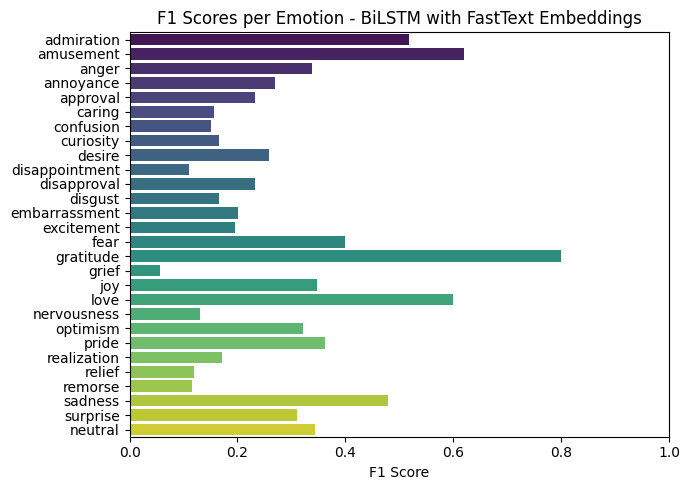

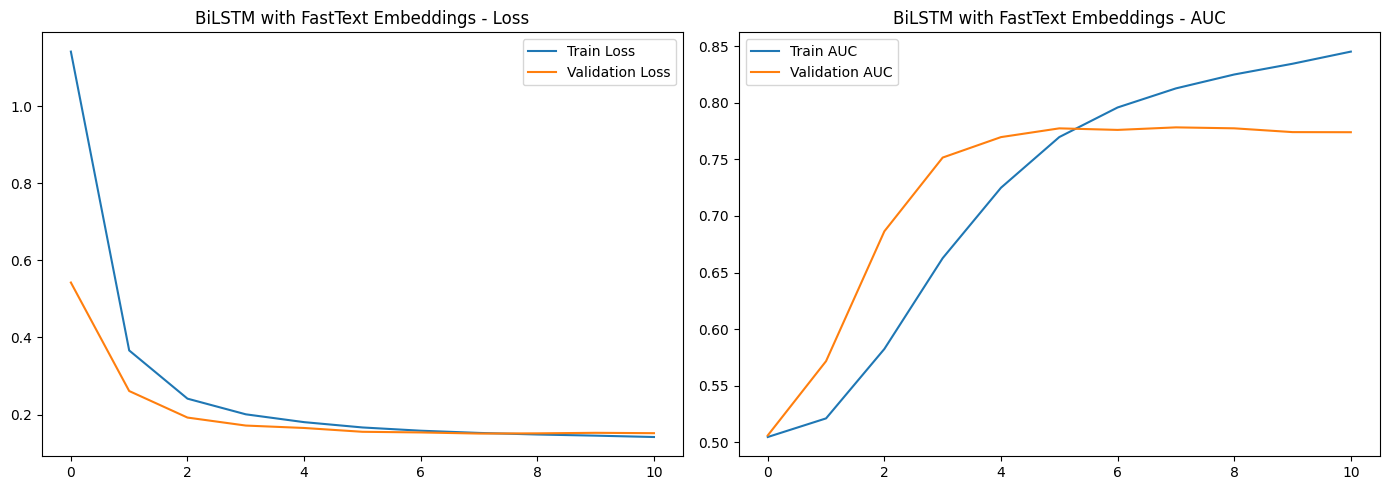

In [26]:
# Train and evaluate Bi-LSTM model with FastText embeddings
bilstm_ft = bilstm_model(embedding_matrix_ft, embedding_dim=300, num_classes=len(emotion_columns), use_focal_loss=False  )
bilstm_model_ft, bilstm_history_ft = train_dl_model(
    bilstm_ft,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM with FastText Embeddings",
    emotion_columns=emotion_columns,
    epochs=20,
    batch_size=128
)

=== BiLSTM (Focal Loss) with Word2Vec Embeddings ===
Epoch 1/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1220s 1s/step - accuracy: 0.6893 - auc: 0.5123 - loss: 1.2830 - precision: 0.0498 - recall: 0.3092 - val_accuracy: 0.9566 - val_auc: 0.5896 - val_loss: 0.2721 - val_precision: 0.8616 - val_recall: 0.0180 - learning_rate: 1.0000e-04
Epoch 2/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1205s 1s/step - accuracy: 0.9477 - auc: 0.5521 - loss: 0.2090 - precision: 0.1645 - recall: 0.0305 - val_accuracy: 0.9571 - val_auc: 0.6857 - val_loss: 0.0802 - val_precision: 0.8995 - val_recall: 0.0289 - learning_rate: 1.0000e-04
Epoch 3/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1208s 1s/step - accuracy: 0.9536 - auc: 0.5995 - loss: 0.0760 - precision: 0.4895 - recall: 0.0312 - val_accuracy: 0.9574 - val_auc: 0.7199 - val_loss: 0.0500 - val_precision: 0.8576 - val_recall: 0.0396 - learning_rate: 1.0000e-04
Epoch 4/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1225s 1s/step - accuracy: 0.9547 - auc: 0.6445 - loss: 0.0534 - precision: 0.6679 - recall:

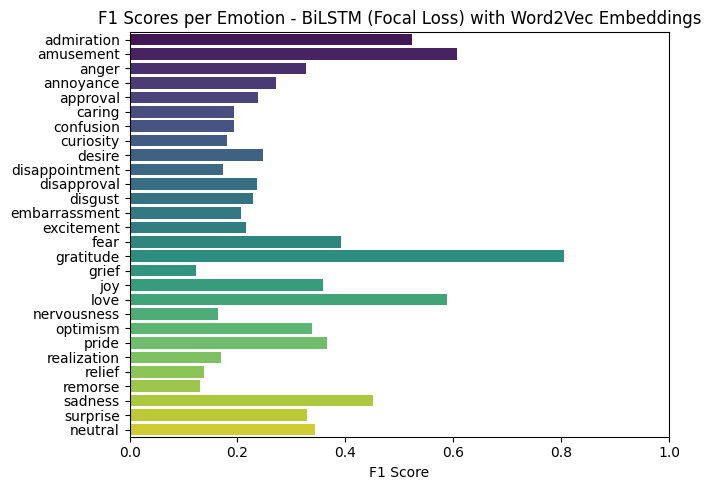

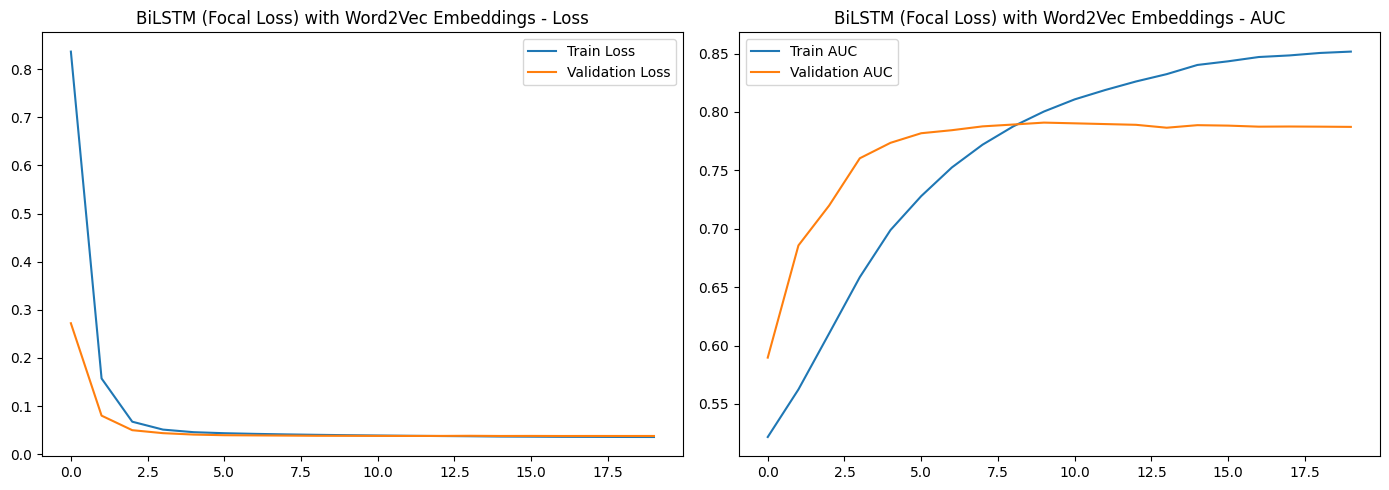

In [27]:
# Train and evaluate Bi-LSTM model with Word2Vec embeddings (Focal loss to handle class imbalance)
bilstm_focal_w2v = bilstm_model(embedding_matrix_w2v, embedding_dim=300, num_classes=len(emotion_columns),use_focal_loss=True)
bilstm_focal_w2v_model, bilstm_focal_w2v_history = train_dl_model(
    bilstm_focal_w2v,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM (Focal Loss) with Word2Vec Embeddings",
    emotion_columns=emotion_columns,
    epochs=25,
    batch_size=128
)

=== BiLSTM (Focal Loss) with FastText Embeddings ===
Epoch 1/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1576s 2s/step - accuracy: 0.7496 - auc: 0.5153 - loss: 1.2343 - precision: 0.0519 - recall: 0.2534 - val_accuracy: 0.9559 - val_auc: 0.5973 - val_loss: 0.2252 - val_precision: 0.1176 - val_recall: 2.5754e-05 - learning_rate: 1.0000e-04
Epoch 2/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1605s 2s/step - accuracy: 0.9486 - auc: 0.5426 - loss: 0.1715 - precision: 0.1049 - recall: 0.0140 - val_accuracy: 0.9562 - val_auc: 0.6584 - val_loss: 0.0674 - val_precision: 0.9048 - val_recall: 0.0061 - learning_rate: 1.0000e-04
Epoch 3/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1598s 2s/step - accuracy: 0.9537 - auc: 0.5822 - loss: 0.0679 - precision: 0.4616 - recall: 0.0213 - val_accuracy: 0.9573 - val_auc: 0.7020 - val_loss: 0.0478 - val_precision: 0.8592 - val_recall: 0.0361 - learning_rate: 1.0000e-04
Epoch 4/25
932/932 ━━━━━━━━━━━━━━━━━━━━ 1912s 2s/step - accuracy: 0.9548 - auc: 0.6279 - loss: 0.0527 - precision: 0.6766 - rec

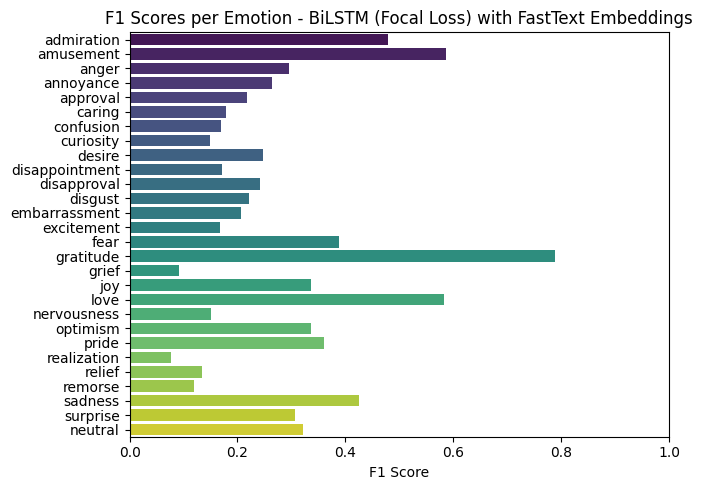

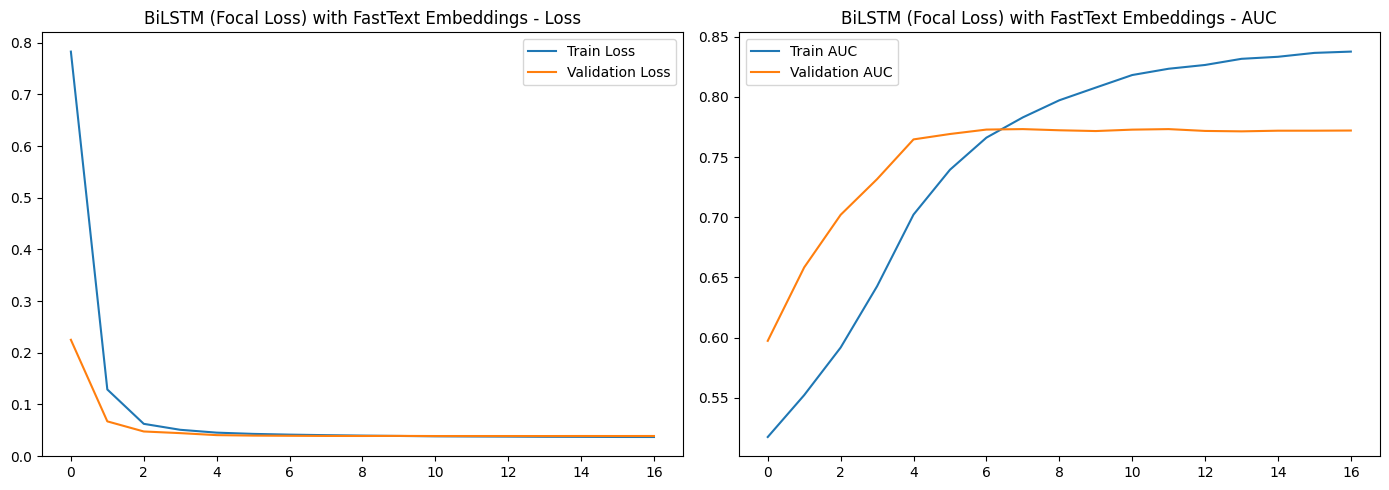

In [28]:
# Train and evaluate Bi-LSTM model with Fasttext embeddings (Focal loss to handle class imbalance)
bilstm_focal_ft = bilstm_model(embedding_matrix_ft, embedding_dim=300, num_classes=len(emotion_columns),use_focal_loss=True)
bilstm_focal_ft_model, bilstm_focal_ft_history = train_dl_model(
    bilstm_focal_ft,
    X_train_pad, y_train_mlb,               
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM (Focal Loss) with FastText Embeddings",
    emotion_columns=emotion_columns,
    epochs=25,
    batch_size=128
)

In [18]:
# Bi-LSTM model with Multi-Head Attention
def multihead_attention_bilstm(embedding_matrix, embedding_dim=300, max_len=100, use_focal_loss=False):
    inputs = Input(shape=(max_len,))  # Use max_len parameter for input shape
    
    # Embedding Layer
    x = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
        mask_zero=True
    )(inputs)
    
    # Bi-LSTM Layer
    x = Bidirectional(LSTM(
        128,  # Increased units for better representation
        return_sequences=True,
        dropout=0.3,
        recurrent_dropout=0.2
    ))(x)
    
    # Attention Mechanism
    attention = MultiHeadAttention(
        num_heads=4, 
        key_dim=64,
        dropout=0.3
    )(x, x)  # Self-attention: query and value are both the LSTM output
    
    # Residual Connection and Layer Normalization
    x = Add()([x, attention])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Pooling and Classification
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)  # Sigmoid for multi-label
    
    # Configure loss and metrics
    if use_focal_loss:
        loss = focal_loss(alpha=0.5, gamma=1.0)
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    else:
        loss = 'binary_crossentropy'
        metrics = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    
    # Model compilation
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=1e-4,
        clipnorm=1.0
    )
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

Embedding -> Bi-LSTM (64) -> Multi-Head Attention (4 heads) -> Residual connection + Layer normalization -> Global Max Pooling -> Dense (64 ReLU, L2 regularization + Dropout) -> Softmax
- Better generalization with dropout and regularization 
- More computationally expensive, complex

=== BiLSTM with Multi-Head Attention and Word2Vec Embeddings ===
Epoch 1/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1631s 2s/step - accuracy: 0.5532 - auc: 0.5292 - loss: 0.8160 - precision: 0.0511 - recall: 0.4907 - val_accuracy: 0.9554 - val_auc: 0.6285 - val_loss: 0.3690 - val_precision: 0.4150 - val_recall: 0.0292 - learning_rate: 1.0000e-04
Epoch 2/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1658s 2s/step - accuracy: 0.9278 - auc: 0.5519 - loss: 0.3497 - precision: 0.0951 - recall: 0.0615 - val_accuracy: 0.9569 - val_auc: 0.6891 - val_loss: 0.1960 - val_precision: 0.8924 - val_recall: 0.0255 - learning_rate: 1.0000e-04
Epoch 3/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1617s 2s/step - accuracy: 0.9536 - auc: 0.6038 - loss: 0.2059 - precision: 0.4675 - recall: 0.0321 - val_accuracy: 0.9580 - val_auc: 0.7505 - val_loss: 0.1675 - val_precision: 0.8084 - val_recall: 0.0600 - learning_rate: 1.0000e-04
Epoch 4/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1641s 2s/step - accuracy: 0.9549 - auc: 0.6666 - loss: 0.1853 - precision: 0.65

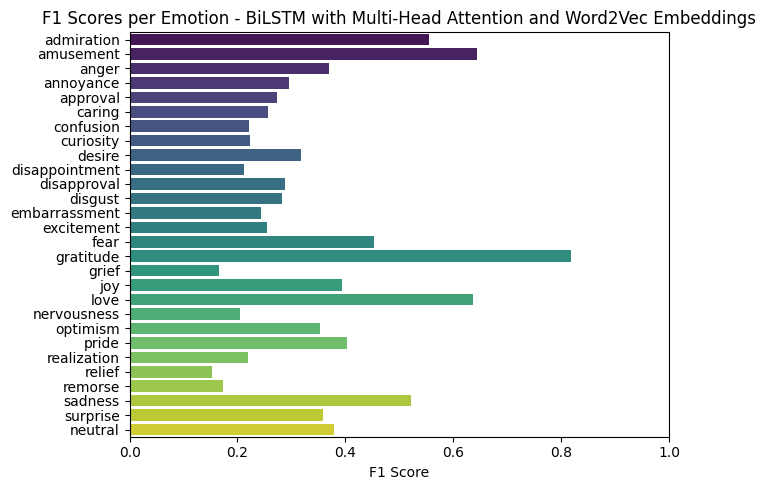

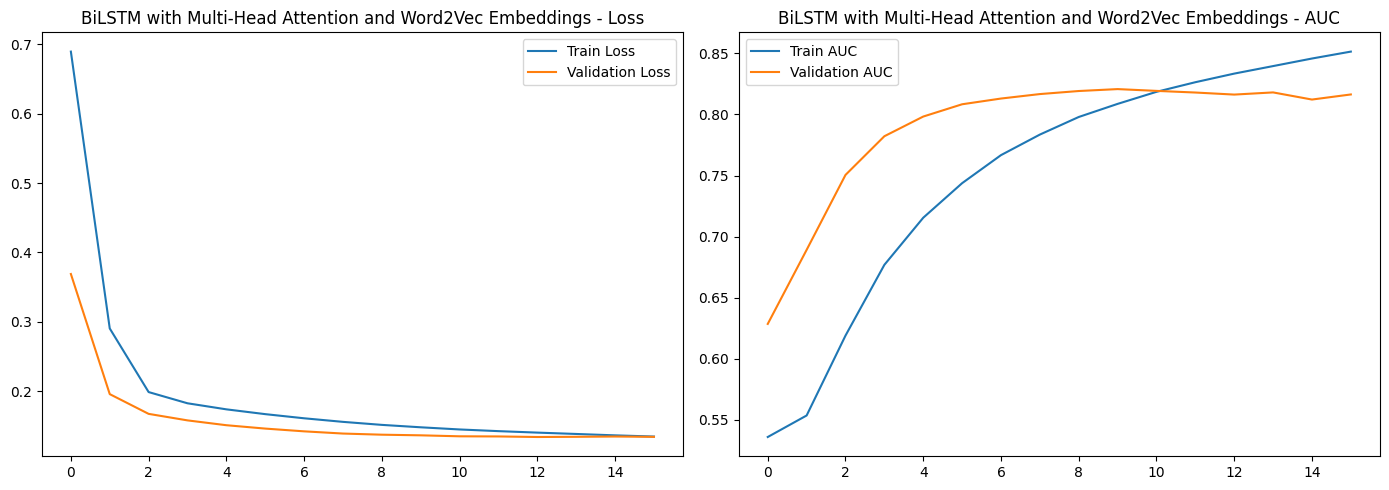

In [20]:
# Train and evaluate Bi-LSTM model with Multi-Head Attention and Word2Vec embeddings
multihead_bilstm_w2v = multihead_attention_bilstm(embedding_matrix_w2v,embedding_dim=300,max_len=100,use_focal_loss=False  )
bilstm_multihead_w2v, bilstm_multihead_history_w2v = train_dl_model(
    multihead_bilstm_w2v,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM with Multi-Head Attention and Word2Vec Embeddings",
    emotion_columns=emotion_columns,
    epochs=30,
    batch_size=128
)

=== BiLSTM with Multi-Head Attention and FastText Embeddings ===
Epoch 1/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1677s 2s/step - accuracy: 0.5675 - auc: 0.5156 - loss: 0.7831 - precision: 0.0493 - recall: 0.4545 - val_accuracy: 0.9546 - val_auc: 0.6257 - val_loss: 0.3684 - val_precision: 0.2452 - val_recall: 0.0144 - learning_rate: 1.0000e-04
Epoch 2/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1624s 2s/step - accuracy: 0.9396 - auc: 0.5420 - loss: 0.3189 - precision: 0.0903 - recall: 0.0310 - val_accuracy: 0.9568 - val_auc: 0.6994 - val_loss: 0.1851 - val_precision: 0.9256 - val_recall: 0.0202 - learning_rate: 1.0000e-04
Epoch 3/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1598s 2s/step - accuracy: 0.9541 - auc: 0.6133 - loss: 0.1995 - precision: 0.5765 - recall: 0.0300 - val_accuracy: 0.9581 - val_auc: 0.7619 - val_loss: 0.1629 - val_precision: 0.7924 - val_recall: 0.0672 - learning_rate: 1.0000e-04
Epoch 4/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1610s 2s/step - accuracy: 0.9554 - auc: 0.6893 - loss: 0.1799 - precision: 0.70

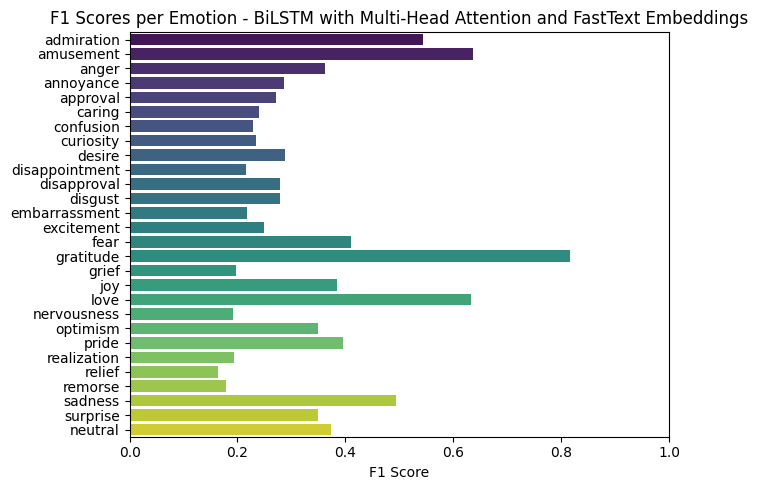

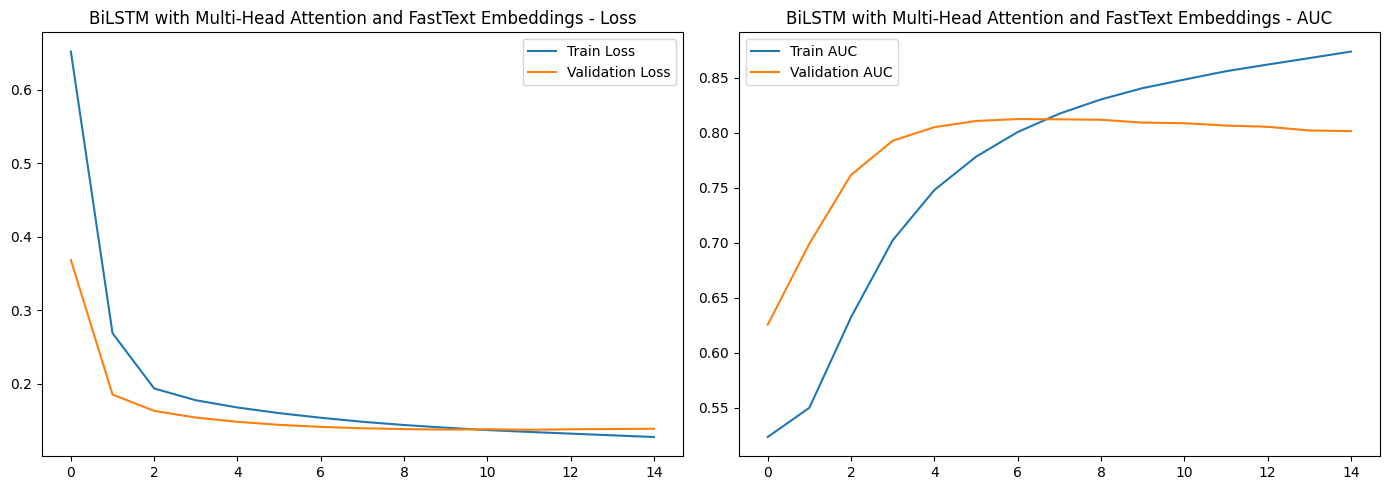

In [20]:
# Train and evaluate Bi-LSTM model with Multi-Head Attention and FastText embeddings
multihead_bilstm_ft = multihead_attention_bilstm(embedding_matrix_ft,embedding_dim=300,max_len=100,use_focal_loss=False  )
bilstm_multihead_ft, bilstm_multihead_history_ft = train_dl_model(
    multihead_bilstm_ft,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM with Multi-Head Attention and FastText Embeddings",
    emotion_columns=emotion_columns,
    epochs=30,
    batch_size=128
)

=== BiLSTM (Focal loss) with Multi-Head Attention and Word2Vec Embeddings ===
Epoch 1/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1713s 2s/step - accuracy: 0.5572 - auc: 0.5208 - loss: 0.2693 - precision: 0.0501 - recall: 0.4749 - val_accuracy: 0.9520 - val_auc: 0.6067 - val_loss: 0.1045 - val_precision: 0.2218 - val_recall: 0.0354 - learning_rate: 1.0000e-04
Epoch 2/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1824s 2s/step - accuracy: 0.9364 - auc: 0.5381 - loss: 0.0896 - precision: 0.0850 - recall: 0.0366 - val_accuracy: 0.9566 - val_auc: 0.6513 - val_loss: 0.0588 - val_precision: 0.9192 - val_recall: 0.0158 - learning_rate: 1.0000e-04
Epoch 3/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1741s 2s/step - accuracy: 0.9527 - auc: 0.5814 - loss: 0.0635 - precision: 0.3466 - recall: 0.0238 - val_accuracy: 0.9573 - val_auc: 0.7279 - val_loss: 0.0524 - val_precision: 0.8633 - val_recall: 0.0369 - learning_rate: 1.0000e-04
Epoch 4/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1757s 2s/step - accuracy: 0.9540 - auc: 0.6403 - loss: 0.0574 - pr

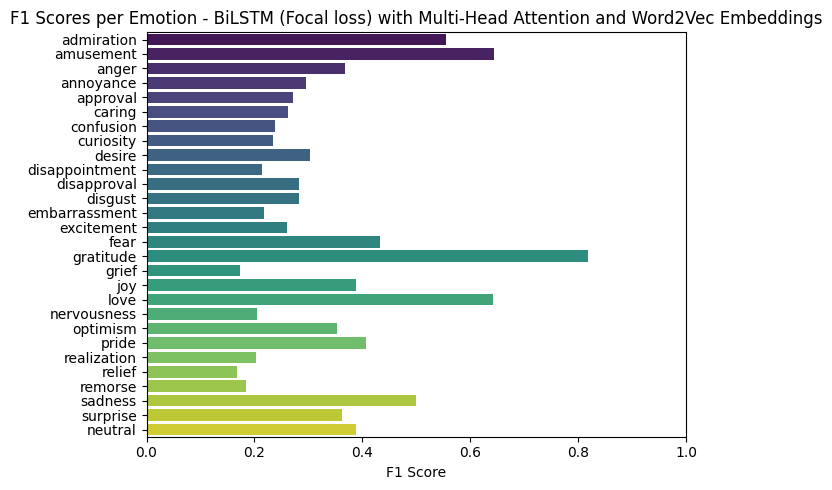

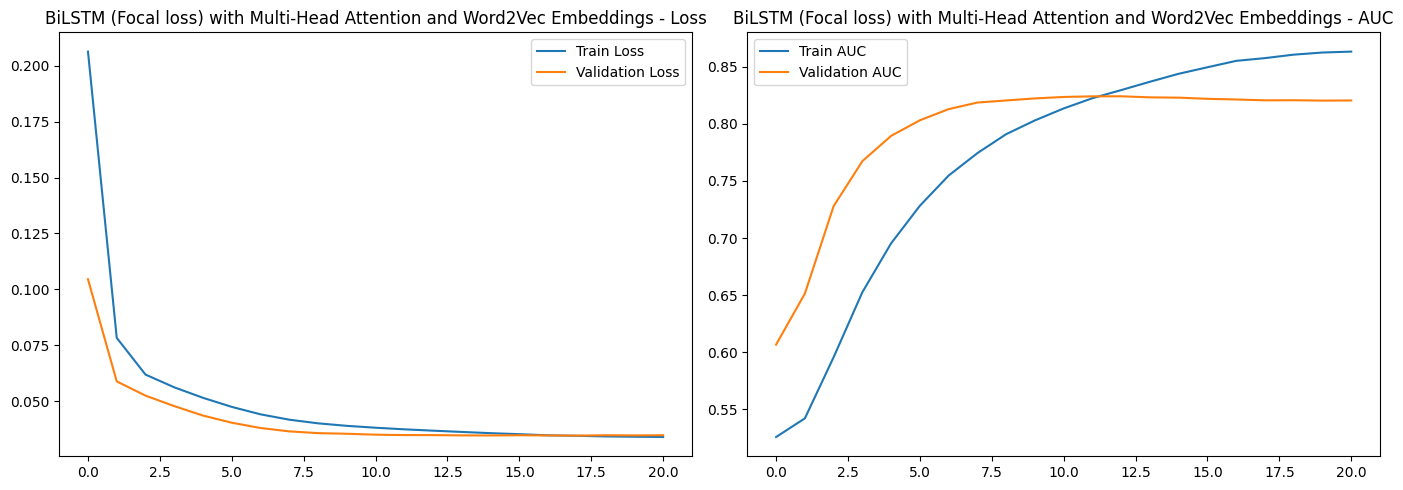

In [19]:
# Train and evaluate Bi-LSTM model with Multi-Head Attention and Word2Vec embeddings (Focal loss to handle class imbalance)
multihead_focal_bilstm_w2v = multihead_attention_bilstm(embedding_matrix_w2v,embedding_dim=300,max_len=100,use_focal_loss=True  )
bilstm_multihead_focal_w2v, bilstm_multihead_focal_history_w2v = train_dl_model(
    multihead_focal_bilstm_w2v,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM (Focal loss) with Multi-Head Attention and Word2Vec Embeddings",
    emotion_columns=emotion_columns,
    epochs=30,
    batch_size=128
)

=== BiLSTM (Focal loss) with Multi-Head Attention and FastText Embeddings ===
Epoch 1/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1520s 2s/step - accuracy: 0.5732 - auc: 0.5102 - loss: 0.2519 - precision: 0.0486 - recall: 0.4424 - val_accuracy: 0.9558 - val_auc: 0.5835 - val_loss: 0.0919 - val_precision: 0.0368 - val_recall: 1.2877e-04 - learning_rate: 1.0000e-04
Epoch 2/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1615s 2s/step - accuracy: 0.9439 - auc: 0.5266 - loss: 0.0838 - precision: 0.0664 - recall: 0.0158 - val_accuracy: 0.9561 - val_auc: 0.6425 - val_loss: 0.0581 - val_precision: 0.9763 - val_recall: 0.0037 - learning_rate: 1.0000e-04
Epoch 3/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1579s 2s/step - accuracy: 0.9530 - auc: 0.5722 - loss: 0.0624 - precision: 0.3162 - recall: 0.0143 - val_accuracy: 0.9573 - val_auc: 0.7221 - val_loss: 0.0520 - val_precision: 0.9000 - val_recall: 0.0335 - learning_rate: 1.0000e-04
Epoch 4/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 1546s 2s/step - accuracy: 0.9542 - auc: 0.6435 - loss: 0.0562 

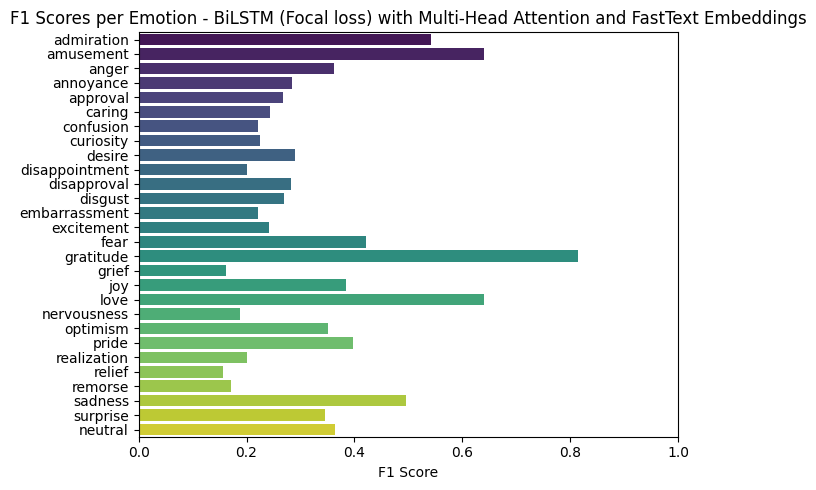

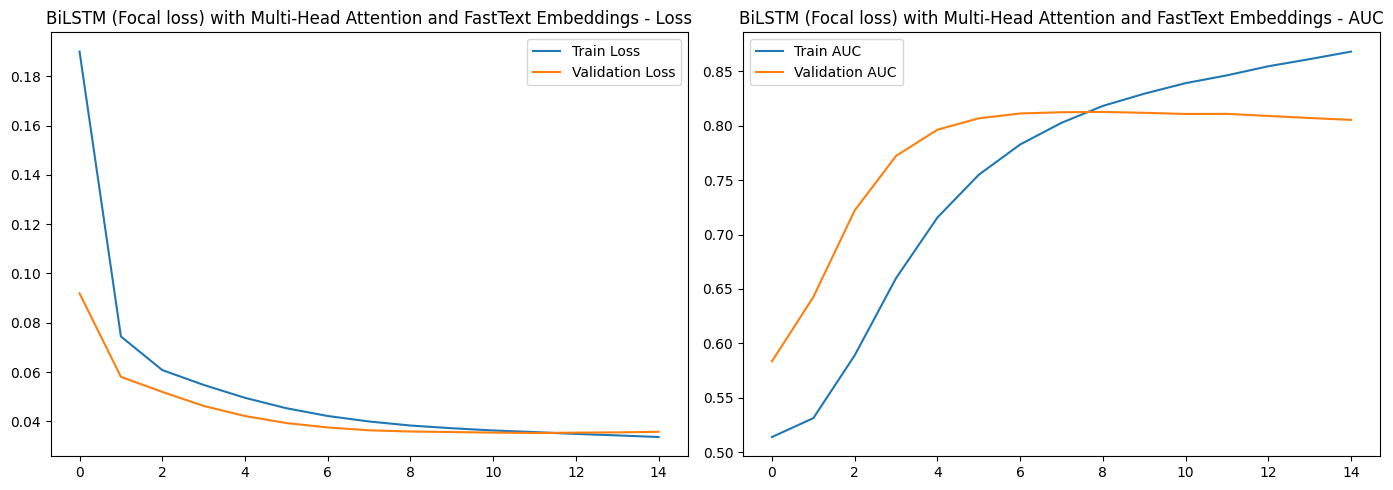

In [19]:
# Train and evaluate Bi-LSTM model with Multi-Head Attention and FastText embeddings (Focal loss to handle class imbalance)
multihead_focal_bilstm_ft = multihead_attention_bilstm(embedding_matrix_ft,embedding_dim=300,max_len=100,use_focal_loss=True  )
bilstm_multihead_focal_ft, bilstm_multihead_focal_history_ft = train_dl_model(
    multihead_focal_bilstm_ft,
    X_train_pad, y_train_mlb,
    X_val_pad, y_val_mlb,
    X_test_pad, y_test_mlb,
    model_name="BiLSTM (Focal loss) with Multi-Head Attention and FastText Embeddings",
    emotion_columns=emotion_columns,
    epochs=30,
    batch_size=128
)

## 6.3 Transformers
- DistilBERT


In [20]:
# Define parameters
max_len = 64
batch_size = 32
epochs = 3

In [11]:
# Convert tokens back to text for Transformers
X_train_trans = [' '.join(tokens) for tokens in X_train]
X_val_trans = [' '.join(tokens) for tokens in X_val]
X_test_trans = [' '.join(tokens) for tokens in X_test]

In [12]:
# Prepare labels (multi-label format)
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(train_df['emotion'])
y_val_mlb = mlb.transform(val_df['emotion'])
y_test_mlb = mlb.transform(test_df['emotion'])

num_classes = len(mlb.classes_)
emotion_columns = mlb.classes_

In [13]:
# Function for tokenization
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

In [14]:
# Create a custom Dataset class for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

In [15]:
# Function to train Transformers model
def train_transformers_model(model, train_loader, val_loader, 
                            model_name, emotion_columns, epochs):
    print(f"=== {model_name} ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)
    
    # Storage for metrics
    train_losses = []
    val_losses = []
    val_metrics = {
        'hamming_loss': [],
        'jaccard_score': [],
        'f1_micro': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        
        # Progress bar setup
        total_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # Forward pass and loss calculation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
            # Print progress
            progress = (batch_idx + 1) / total_batches
            bar_length = 30
            filled_length = int(bar_length * progress)
            bar = '=' * filled_length + ' ' * (bar_length - filled_length)
            print(f"\r{bar} | Batch {batch_idx+1}/{total_batches} | Train Loss: {loss.item():.4f}", end='')
        
        # Calculate average training loss
        avg_train_loss = epoch_train_loss / total_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                # Forward pass and loss calculation (single pass)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                epoch_val_loss += loss.item()
                # Get predictions
                preds = torch.sigmoid(outputs.logits).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())
        
        # Calculate validation metrics
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        all_preds_bin = (all_preds > 0.5).astype(int)

        print(f"\nEpoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        val_f1 = f1_score(all_labels, all_preds_bin, average='micro')
        # Store validation metrics
        val_metrics['hamming_loss'].append(hamming_loss(all_labels, all_preds_bin))
        val_metrics['jaccard_score'].append(jaccard_score(all_labels, all_preds_bin, average='samples'))
        val_metrics['f1_micro'].append(val_f1)

        
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_metrics': val_metrics
    }

In [22]:
# Function to evaluate Transformers model 
def evaluate_transformers_model(model, history, test_loader, emotion_columns, model_name):  
    print(f"=== {model_name} ===")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs.logits).cpu().numpy()
            test_preds.append(preds)
            test_labels.append(labels.cpu().numpy())
    
    test_preds = np.vstack(test_preds)
    test_labels = np.vstack(test_labels)
    test_preds_bin = (test_preds > 0.5).astype(int)  # 3. Use only test_preds
    
    # Calculate test metrics
    test_hamming = hamming_loss(test_labels, test_preds_bin)
    test_jaccard = jaccard_score(test_labels, test_preds_bin, average='samples')
    test_f1 = f1_score(test_labels, test_preds_bin, average='micro')
    
    print(f"\n=== {model_name} ===")
    print(f"Test Hamming Loss: {test_hamming:.4f}")
    print(f"Test Jaccard Score: {test_jaccard:.4f}")
    print(f"Test Micro F1-Score: {test_f1:.4f}")
    
    # Classification report
    print(f"\nClassification Report ({model_name}):\n")
    print(classification_report(test_labels, test_preds_bin, target_names=emotion_columns, zero_division=0))
        
    # Plot F1 scores per emotion
    f1_scores = []
    for i in range(len(emotion_columns)):
        f1 = f1_score(test_labels[:, i], test_preds_bin[:, i])
        f1_scores.append(f1)
    plt.figure(figsize=(7, 5))
    sns.barplot(y=emotion_columns, x=f1_scores, palette="viridis")
    plt.title(f"F1 Scores per Emotion - {model_name}")
    plt.xlabel("F1 Score")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(6, 4))
    # Loss plot
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return {
        'hamming_loss': test_hamming,
        'jaccard_score': test_jaccard,
        'f1_micro': test_f1
    }


### 6.3.1 DistilBERT

In [17]:
# Initialize tokenizer
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize texts for train, validation, and test sets
train_encodings = tokenize_texts(X_train_trans, distilbert_tokenizer)
val_encodings = tokenize_texts(X_val_trans, distilbert_tokenizer)
test_encodings = tokenize_texts(X_test_trans, distilbert_tokenizer)

In [18]:
# Create datasets for train, validation, and test
train_dataset = EmotionDataset(train_encodings, y_train_mlb)
val_dataset = EmotionDataset(val_encodings, y_val_mlb)
test_dataset = EmotionDataset(test_encodings, y_test_mlb)

# Training configuration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# DistilBERT model 
num_labels = y_train_mlb.shape[1]
model_distilbert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels = num_labels,
    problem_type = "multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Train and validate DistilBERT model
distilbert_model, distilbert_history = train_transformers_model(
    model=model_distilbert,
    train_loader = train_loader,
    val_loader = val_loader,
    model_name = "DistilBERT",
    emotion_columns = emotion_columns,
    epochs = epochs
)

=== DistilBERT ===

Epoch 1/3
============================== | Batch 7455/7455 | Train Loss: 0.0968
Epoch 1 | Train Loss: 0.1456 | Val Loss: 0.1340

Epoch 2/3
============================== | Batch 7455/7455 | Train Loss: 0.1606
Epoch 2 | Train Loss: 0.1156 | Val Loss: 0.1394

Epoch 3/3
============================== | Batch 7455/7455 | Train Loss: 0.1434
Epoch 3 | Train Loss: 0.0934 | Val Loss: 0.1524


=== DistilBERT ===

=== DistilBERT ===
Test Hamming Loss: 0.0467
Test Jaccard Score: 0.2441
Test Micro F1-Score: 0.3229

Classification Report (DistilBERT):

                precision    recall  f1-score   support

    admiration       0.55      0.51      0.53      5996
     amusement       0.58      0.60      0.59      3236
         anger       0.40      0.27      0.32      2829
     annoyance       0.28      0.14      0.19      4766
      approval       0.35      0.14      0.20      6167
        caring       0.37      0.13      0.19      2099
     confusion       0.31      0.21      0.25      2576
     curiosity       0.36      0.19      0.25      3392
        desire       0.26      0.28      0.27      1336
disappointment       0.29      0.08      0.12      2964
   disapproval       0.30      0.17      0.21      3999
       disgust       0.47      0.12      0.19      1856
 embarrassment       0.21      0.18      0.19       867
    excitement       0.34      0.11      0.17      1970
 

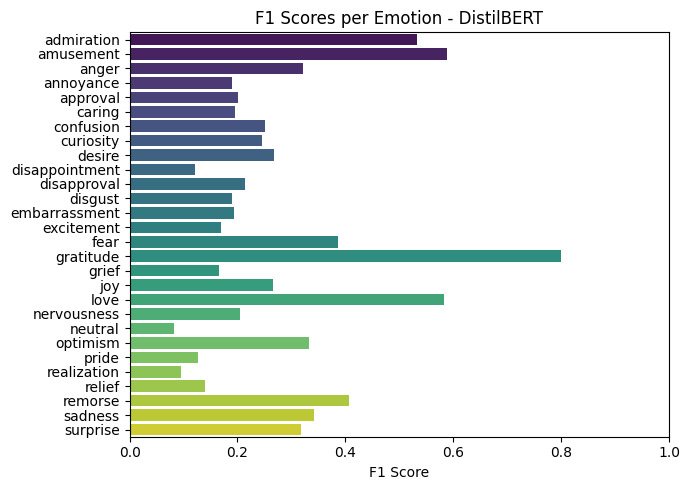

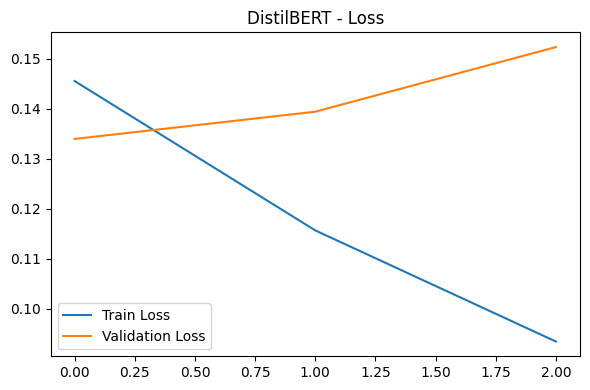

In [23]:
# Evaluate on test set 
distilbert_metrics = evaluate_transformers_model(
    distilbert_model, 
    distilbert_history,
    test_loader, 
    emotion_columns, 
    model_name="DistilBERT",
)

In [24]:
from pathlib import Path
import joblib
# Create model directory
model_dir = Path("model_directory/distilbert")
model_dir.mkdir(exist_ok=True)

# Save individual models
distilbert_model.save_pretrained(model_dir/"distilbert_model")

# Save tokenizers
distilbert_tokenizer.save_pretrained(model_dir/"distilbert_tokenizer")

# Save label binarizer
joblib.dump(mlb, model_dir / "label_binarizer.pkl")

# Save metadata 
metadata = {
    "max_len": max_len,
    "num_labels": num_labels,
}
with open(model_dir/"metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

# 7.0 Deployment

In [ ]:
# Create model directory
model_dir = Path("model_directory/xgboost")
model_dir.mkdir(exist_ok=True)

# Save XGBoost models (OneVsRest)
import joblib
for i, est in enumerate(xgb_tfidf.estimators_):
    joblib.dump(est, model_dir / f"xgb_model_label_{i}.joblib")

# Then save it
with open(model_dir / "tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

# Save metadata
metadata = {
    "max_features": 10000,
    "emotion_columns": emotion_columns  # store emotion column names
}
with open(model_dir / "metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

In [37]:
# Create model directory
model_dir = Path("model_directory")
model_dir.mkdir(exist_ok=True)

# Save individual models
distilbert_model.save_pretrained(model_dir/"distilbert_model")

# Save tokenizers
tokenizer_distilbert.save_pretrained(model_dir/"distilbert_tokenizer")


# Save metadata 
metadata = {
    "max_len": max_len,
    "num_labels": num_labels,
}
with open(model_dir/"metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

In [ ]:
# Deployment
class SoftVotingEnsemble:
    def __init__(self, model_dir):
        self.model_dir = Path(model_dir)
        self.max_len = 64  # Update from metadata if saved
        
        # Load models
        self.bert_model = TFBertForSequenceClassification.from_pretrained(self.model_dir/"bert_model")
        self.xlnet_model = TFXLNetForSequenceClassification.from_pretrained(self.model_dir/"xlnet_model")
        self.roberta_model = TFRobertaForSequenceClassification.from_pretrained(self.model_dir/"roberta_model")
        
        # Load tokenizers
        self.bert_tokenizer = BertTokenizer.from_pretrained(self.model_dir/"bert_tokenizer")
        self.xlnet_tokenizer = XLNetTokenizer.from_pretrained(self.model_dir/"xlnet_tokenizer")
        self.roberta_tokenizer = RobertaTokenizer.from_pretrained(self.model_dir/"roberta_tokenizer")
        
        # Load label encoder
        with open(self.model_dir/"label_encoder.pkl", "rb") as f:
            self.label_encoder = pickle.load(f)
            
    def preprocess(self, text):
        def _encode(tokenizer, text):
            return tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_len,
                return_tensors='tf'
            )
        return {
            'bert': _encode(self.bert_tokenizer, text),
            'xlnet': _encode(self.xlnet_tokenizer, text),
            'roberta': _encode(self.roberta_tokenizer, text)
        }
    
    def predict(self, text):
        # Preprocess input
        encodings = self.preprocess(text)
        
        # Get probabilities from each model
        bert_probs = tf.nn.softmax(self.bert_model(encodings['bert']).logits, axis=1)
        xlnet_probs = tf.nn.softmax(self.xlnet_model(encodings['xlnet']).logits, axis=1)
        roberta_probs = tf.nn.softmax(self.roberta_model(encodings['roberta']).logits, axis=1)
        
        # Average probabilities
        avg_probs = (bert_probs + xlnet_probs + roberta_probs) / 3
        final_pred = np.argmax(avg_probs, axis=1)
        
        return self.label_encoder.inverse_transform(final_pred)[0]

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()
ensemble = SoftVotingEnsemble("model directory")

class TextRequest(BaseModel):
    text: str

@app.post("/predict")
def predict(request: TextRequest):
    return {"prediction": ensemble.predict(request.text)}